### Imports

In [1]:
import numpy as np
import os
from IPython import display

import pandas as pd
import matplotlib.pyplot as plt

import ruptures as rpt
import neurokit2 as nk

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.multivariate.manova import MANOVA


from scipy.stats import shapiro, kstest, jarque_bera, chi2, yeojohnson
from scipy.spatial.distance import mahalanobis

import pingouin as pg

import warnings
warnings.filterwarnings("ignore")

# ....

In [2]:
def derive_formula(model):
    """ Derives linear formula from model """
    predictors = model.model.exog_names
    response = model.model.endog_names
    formula = f"{response} ~ " + " + ".join(predictors)
    return formula

def detect_outliers(series):
    """ Detects outliers based on IQR """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))
    return series[outlier_mask]


In [3]:
# Make True to repeat analysis with annotation segmented data 
CPA = False

### Load data

In [4]:
# Load dataset
data_path = 'preprocessed_data/iv_dv_data_cpa.csv' if CPA else 'preprocessed_data/iv_dv_data.csv'
    
orig_full_data = pd.read_csv(data_path)
orig_full_data.head()

participant  InterludeDuration  Interlude Video Count  \
0            1            959.959                    3.0   
1            2            929.376                    3.0   
2            3           1237.459                    4.0   
3            4            890.543                    3.0   
4            5            623.793                    2.0   

   Interlude Low Arousal  LowArousalRatioLog  Low Ar. vid. bfr 2nd  \
0                    2.0             -0.2877                   1.0   
1                    2.0             -0.2877                   2.0   
2                    2.0             -0.5108                   1.0   
3                    3.0              0.0000                   3.0   
4                    2.0              0.0000                   2.0   

   Low Ar. time bfr 2nd  scary_1st_ecg_Heart Rate  scary_1st_ecg_HRV SDNN  \
0              386.7500                   84.2370                108.0810   
1              623.7917                   66.0308                 51.1301   
2              400.1250                   73.6807                 89.9760   
3              890.5430                   55.4501                112.0262   
4              623.7930                   68.8183                 95.9524   

   scary_1st_ecg_Mean RR Interval  ...  diff_ecg_Mean RR Interval  \
0                        712.7527  ...                    46.9068   
1                        909.1592  ...                     7.1165   
2                        811.3719  ...                   -91.9679   
3                       1074.7197  ...                    -8.5776   
4                        872.0844  ...                   -57.3987   

   scary_1st_gsr_SCL  scary_1st_gsr_SCR  scary_1st_gsr_Peak Amplitude  \
0            10.8722            -0.0001                        0.5107   
1            26.9151            -0.0002                        1.6849   
2            27.2525             0.0018                        0.6584   
3            18.3048            -0.0052                        1.9035   
4            36.6391            -0.0003                        4.7118   

   scary_2nd_gsr_SCL  scary_2nd_gsr_SCR  scary_2nd_gsr_Peak Amplitude  \
0             5.9645             0.0001                        0.0665   
1            30.2707             0.0014                        1.1131   
2            29.5081            -0.0025                        0.7731   
3            27.5351            -0.0022                        2.6668   
4            37.9998            -0.0049                        3.0136   

   diff_gsr_SCL  diff_gsr_SCR  diff_gsr_Peak Amplitude  
0       -4.9077        0.0001                  -0.4442  
1        3.3557        0.0016                  -0.5718  
2        2.2556       -0.0043                   0.1148  
3        9.2303        0.0030                   0.7632  
4        1.3607       -0.0046                  -1.6982  

[5 rows x 25 columns]

In [5]:
orig_data = orig_full_data.copy()
# Keep only relevant columns
relevant_columns = ['participant', 'InterludeDuration', 'LowArousalRatioLog', 'Low Ar. time bfr 2nd', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL']
orig_data = orig_data[relevant_columns]
orig_data = orig_data.set_index('participant', drop=True)
orig_data.head()

InterludeDuration  LowArousalRatioLog  Low Ar. time bfr 2nd  \
participant                                                                
1                      959.959             -0.2877              386.7500   
2                      929.376             -0.2877              623.7917   
3                     1237.459             -0.5108              400.1250   
4                      890.543              0.0000              890.5430   
5                      623.793              0.0000              623.7930   

             diff_ecg_Heart Rate  diff_gsr_Peak Amplitude  diff_gsr_SCL  
participant                                                              
1                        -5.2395                  -0.4442       -4.9077  
2                        -0.5140                  -0.5718        3.3557  
3                         9.6860                   0.1148        2.2556  
4                         0.8651                   0.7632        9.2303  
5                         4.8350                  -1.6982        1.3607

# Multivariate Multiple Regression (ECG-GSR data)

In [6]:
orig_data = orig_full_data.copy()
# Keep only relevant columns
relevant_columns = ['participant', 'InterludeDuration', 'LowArousalRatioLog', 'Low Ar. time bfr 2nd', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL', 'diff_gsr_SCR']
orig_data = orig_full_data[relevant_columns]
orig_data = orig_data.set_index('participant', drop=True)
orig_data.head()

InterludeDuration  LowArousalRatioLog  Low Ar. time bfr 2nd  \
participant                                                                
1                      959.959             -0.2877              386.7500   
2                      929.376             -0.2877              623.7917   
3                     1237.459             -0.5108              400.1250   
4                      890.543              0.0000              890.5430   
5                      623.793              0.0000              623.7930   

             diff_ecg_Heart Rate  diff_gsr_Peak Amplitude  diff_gsr_SCL  \
participant                                                               
1                        -5.2395                  -0.4442       -4.9077   
2                        -0.5140                  -0.5718        3.3557   
3                         9.6860                   0.1148        2.2556   
4                         0.8651                   0.7632        9.2303   
5                         4.8350                  -1.6982        1.3607   

             diff_gsr_SCR  
participant                
1                  0.0001  
2                  0.0016  
3                 -0.0043  
4                  0.0030  
5                 -0.0046

## Independent variables inspection

In [7]:
# Load data
data = orig_data.copy()
# Set dependent variable
response_var = 'diff_ecg_Heart Rate'
# Set predictors
x1, x2 = 'InterludeDuration', 'LowArousalRatioLog'

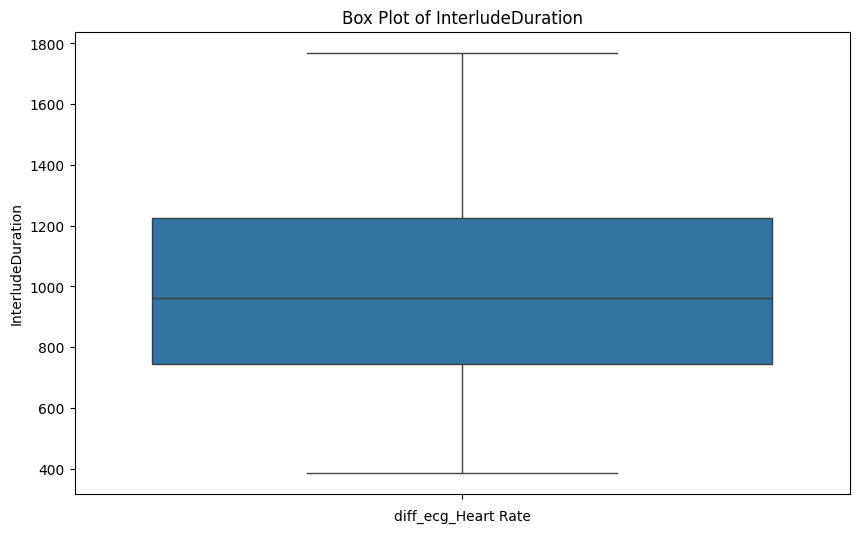

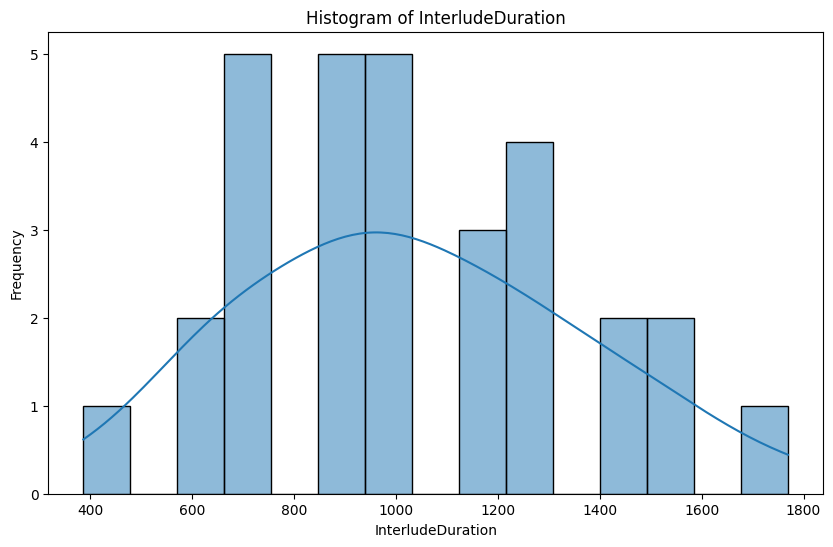

In [8]:
# Check independent variables
x = x1

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[x])
plt.title(f'Box Plot of {x}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[x])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[x], kde=True, bins=15)
plt.xlabel(f'{x}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {x}')
plt.show()

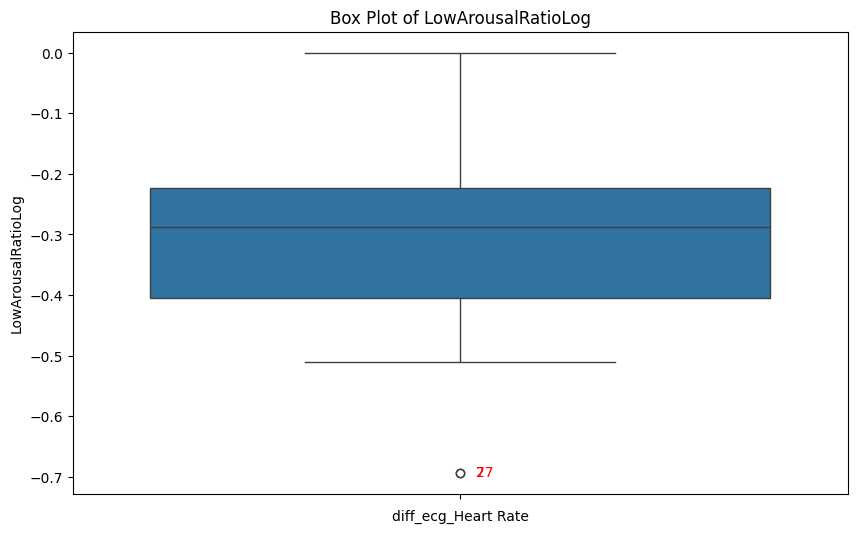

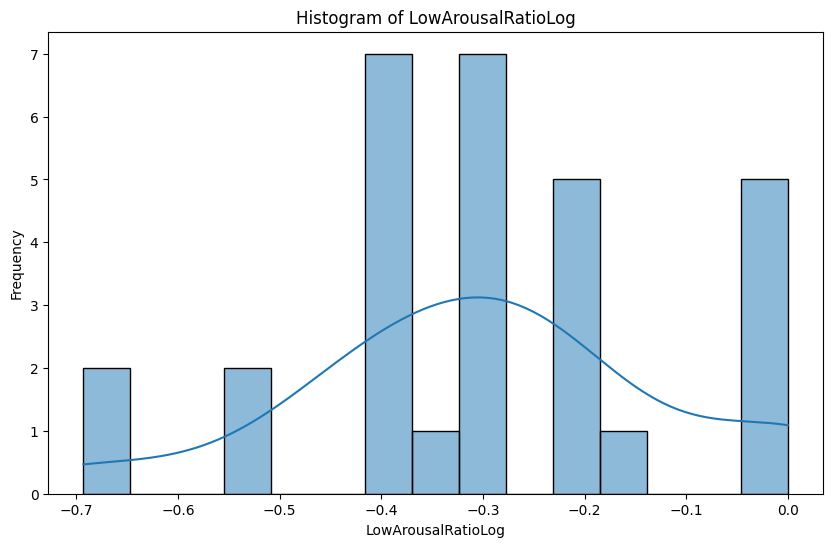

In [9]:
# Check independent variables
x = x2

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[x])
plt.title(f'Box Plot of {x}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[x])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[x], kde=True, bins=15)
plt.xlabel(f'{x}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {x}')
plt.show()

In [10]:
ivs = [x1, x2]  

# Calculate the standard deviation for each independent variable
std_devs = data[ivs].std()

# Check for non-zero variance and print results
print("Standard Deviations of Independent Variables:")
print(std_devs)

# Identify any variables with zero or near-zero variance
near_zero_variance = std_devs[std_devs < 1e-4]  # threshold can be adjusted
if not near_zero_variance.empty:
    print("\nVariables with near-zero variance:")
    print(near_zero_variance)
else:
    print("\nNo variables with near-zero variance detected.")

Standard Deviations of Independent Variables:
InterludeDuration     325.835701
LowArousalRatioLog      0.183010
dtype: float64

No variables with near-zero variance detected.


## ECG Heart Rate

#### Set variables

In [11]:
# Load data
data = orig_data.copy()
# data.head()

In [12]:
# Set dependent variable
response_var = 'diff_ecg_Heart Rate'
# Set predictors
x1, x2 = 'InterludeDuration', 'LowArousalRatioLog'

#### Assumptions checking

##### Preprocess dependents for assumptions 

###### Outlier issues: Remove outlier

In [13]:
# data = orig_data.copy()
# # data.head()
# # Specify outliers to remove
# outlier_ids = []
# for i in outlier_ids:
#     data.drop(i, inplace=True)
# # data.head()

###### Normality issues: Log transform

In [14]:
# # Find the minimum value and shift data to be positive
# shifted_data = data[response_var] - data[response_var].min() + 1
# # Log transform
# data[response_var + '_log'] = np.log(shifted_data)

# response_var = response_var + '_log'

##### Initial visualization

###### Dependent variables inspection

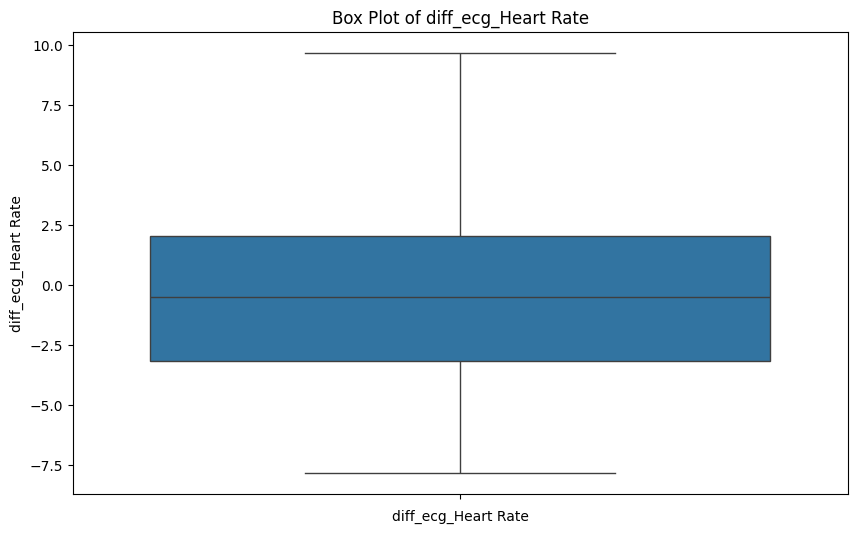

In [15]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[response_var])
plt.title(f'Box Plot of {response_var}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[response_var])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

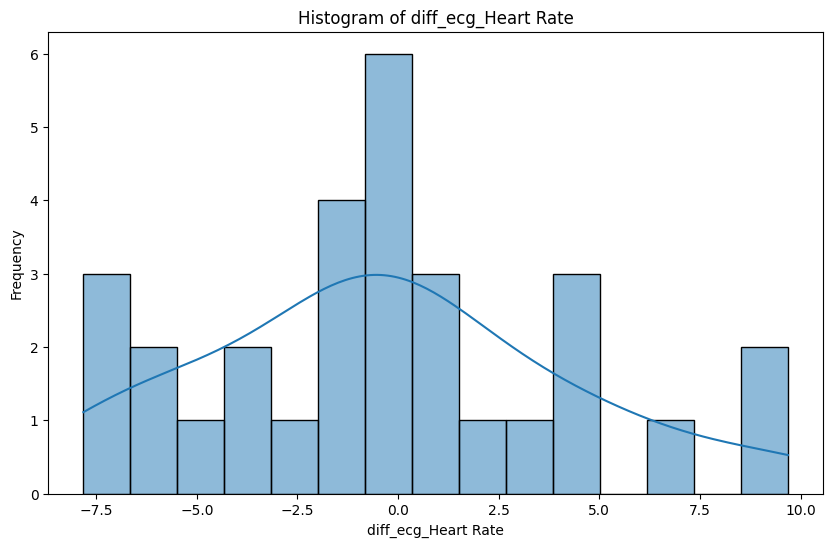

In [16]:
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[response_var], kde=True, bins=15)
plt.xlabel(f'{response_var}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {response_var}')
plt.show()

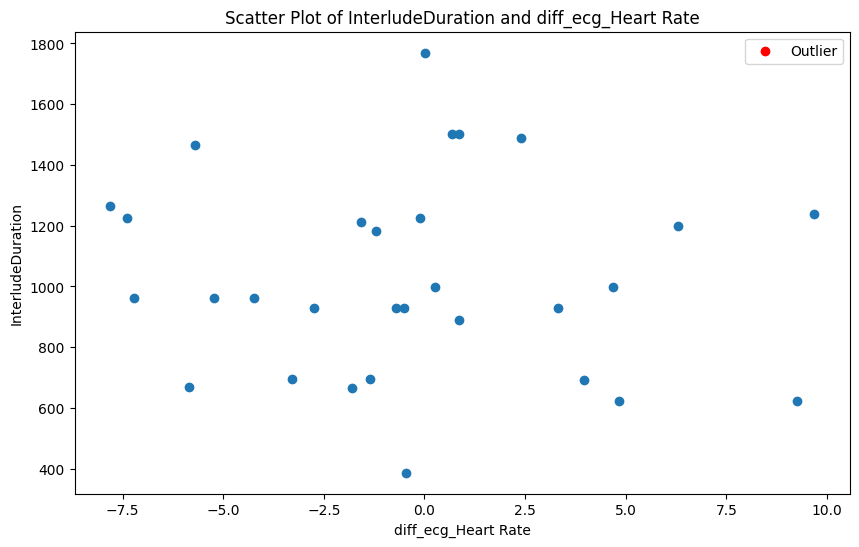

In [17]:
iv = x1
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

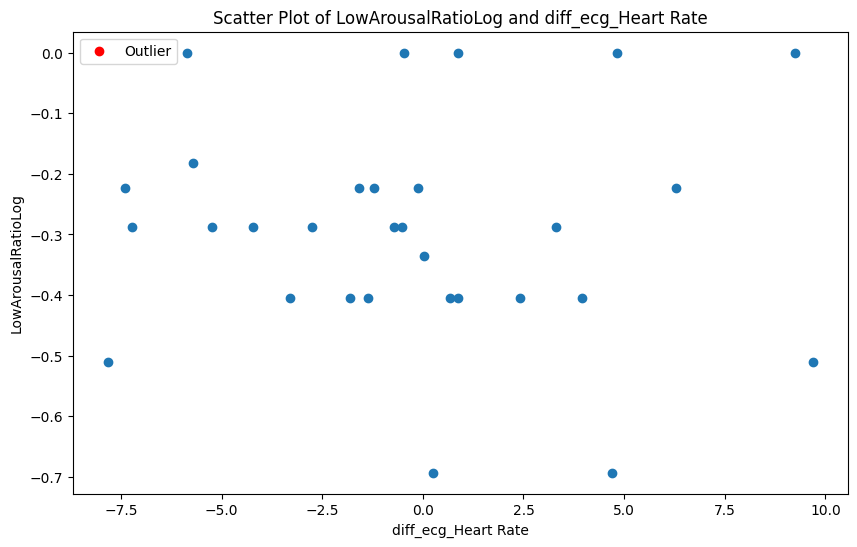

In [18]:
iv = x2
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

##### Residuals analysis

In [19]:
# Select predictors 
X = data[[x1, x2]]

# Define model with interaction term (in case it is needed)
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction[x1] * X_w_interaction[x2]

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models
model_no_interaction = sm.OLS(data[response_var], X).fit()
model_w_interaction = sm.OLS(data[response_var], X_w_interaction).fit()


In [20]:
model = model_no_interaction

###### Outliers

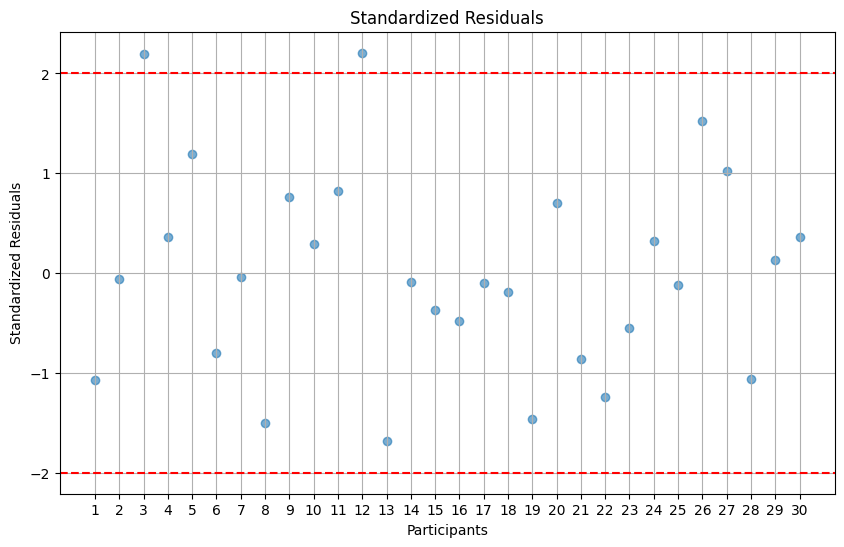

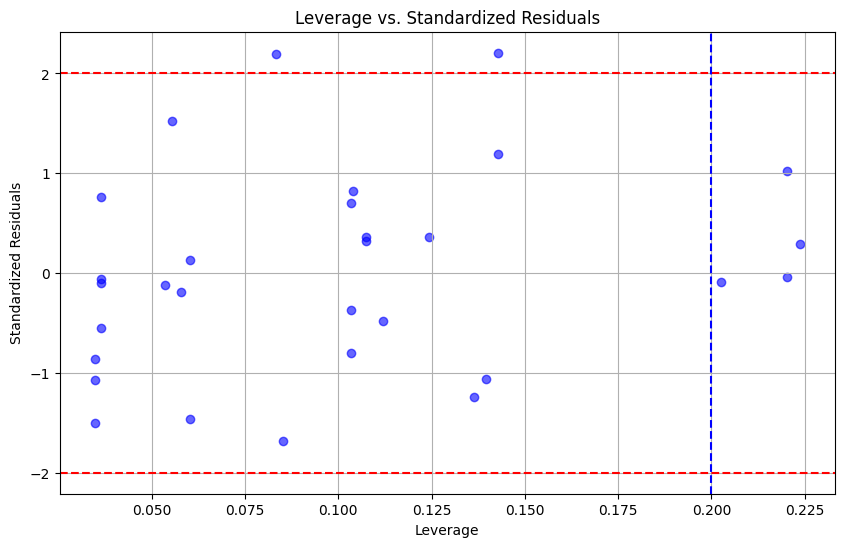

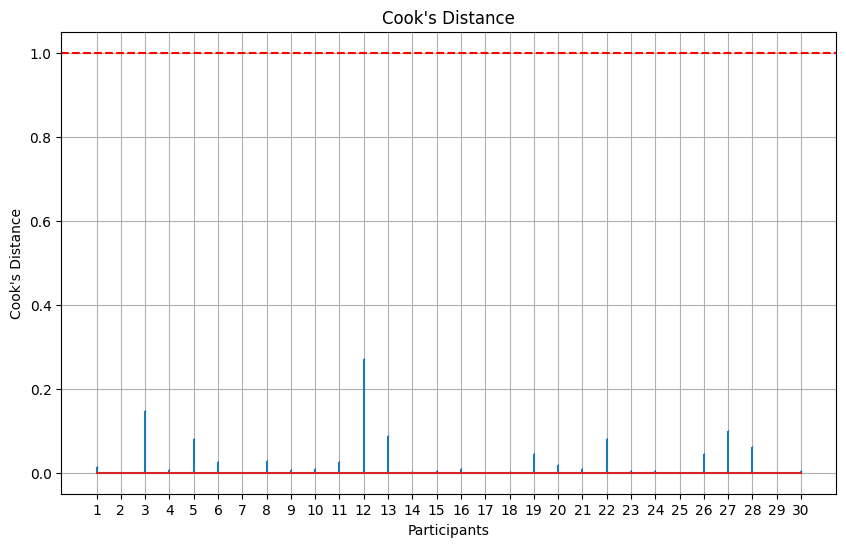

Influential points based on Cook's distance: []


In [21]:
# Standardized Residuals
model.resid_standardized = model.get_influence().resid_studentized_internal

# Leverage
leverage = model.get_influence().hat_matrix_diag

# Cook's Distance
cooks_d = model.get_influence().cooks_distance[0]

# Plot 1
# Plot Standardized Residuals
plt.figure(figsize=(10, 6))
plt.scatter(data.index, model.resid_standardized, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals')
plt.grid(True)
plt.show()

# Plot 2
# Identify outliers (to viually mark)
outlier_mask = abs(model.resid_standardized) > 2.5 # between the 2 and 3 conventions
outlier_indices = data.index[outlier_mask] 

# Plot Leverage vs. Standardized Residuals
plt.figure(figsize=(10, 6))
# Mark outliers using red
plt.scatter(leverage, model.resid_standardized, alpha=0.6, color='blue')  
plt.scatter(leverage[outlier_mask], model.resid_standardized[outlier_mask], alpha=0.6, color='red')  
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axvline(2 * (len(model.params)) / len(model.resid), color='blue', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs. Standardized Residuals')

# Annotate outlier with participant index 
for index, lev, res in zip(outlier_indices, leverage[outlier_mask], model.resid_standardized[outlier_mask]):
    plt.text(lev+0.008, res, str(index), fontsize=9, ha='right')

plt.grid(True)
plt.show()

# Plot 3
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(data.index, cooks_d, markerfmt=",")
plt.axhline(1, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.grid(True)
plt.show()

# Identify points with high Cook's distance
influential_points = np.where(cooks_d > 1)[0]
print(f"Influential points based on Cook's distance: {influential_points}")



###### Normality

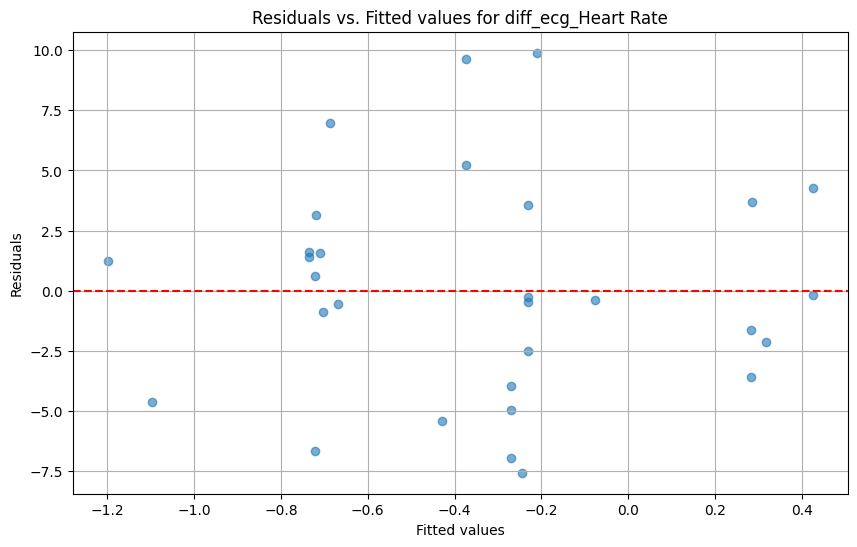

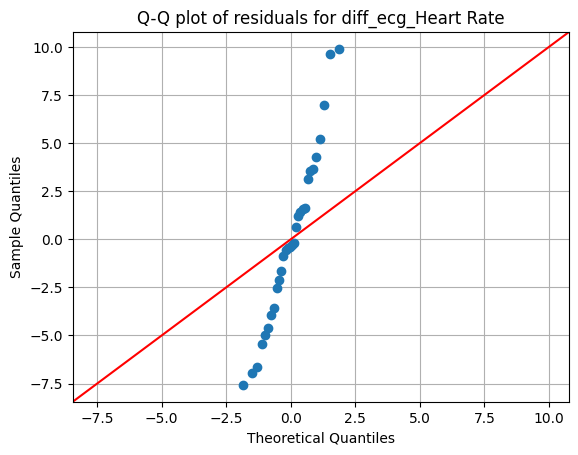

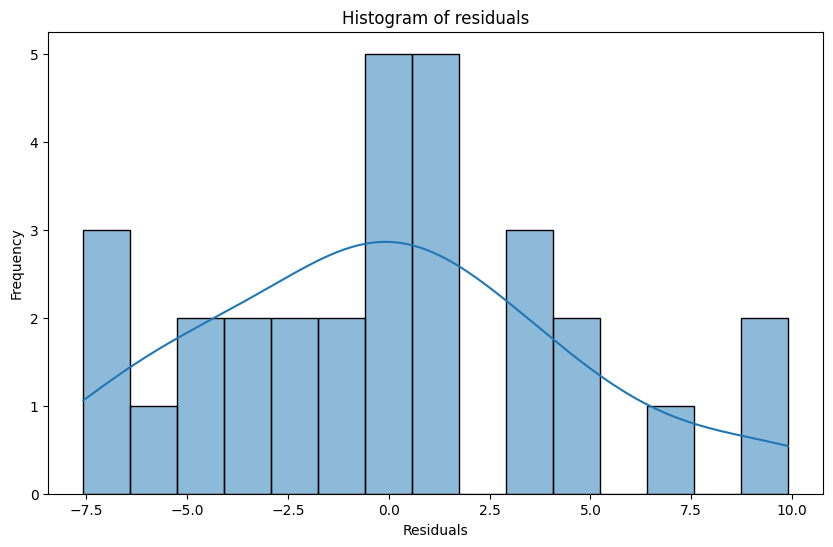

Shapiro-Wilk test: ShapiroResult(statistic=0.9713904857635498, pvalue=0.5778843760490417)
Jarque-Bera test: SignificanceResult(statistic=0.7856672961660937, pvalue=0.6751410492528325)


In [22]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Fitted values for {response_var}')
plt.grid(True)
plt.show()

# Q-Q plot for residuals
sm.qqplot(model.resid, line='45')
plt.title(f'Q-Q plot of residuals for {response_var}')
plt.grid(True)
plt.show()

# Create histogram 
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True, bins=15)
plt.xlabel(f'Residuals')
plt.ylabel('Frequency')
plt.title(f'Histogram of residuals')
plt.show()

# Additional tests

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

###### Independence of residuals

In [23]:
# Durbin-Watson test for independence
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.059233013908885


###### Homoscedasticity

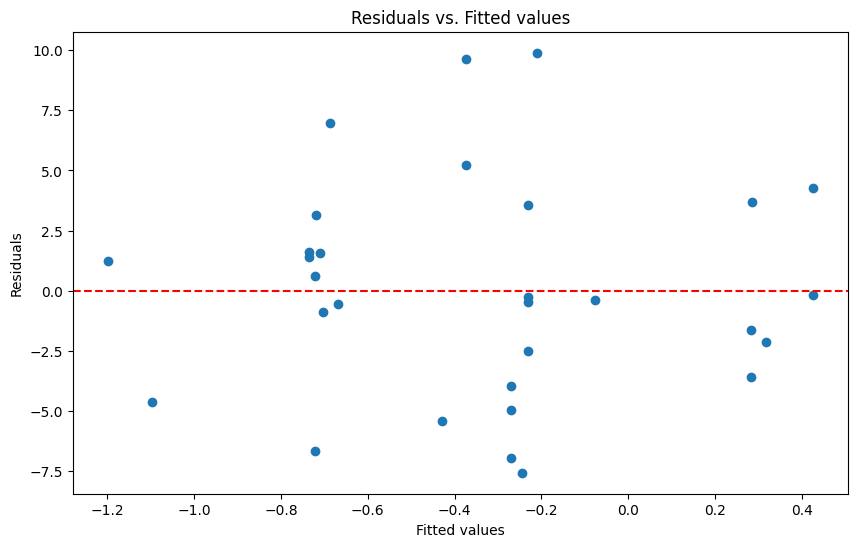

{'LM Statistic': 0.15048044639570102, 'LM-Test p-value': 0.9275206475880711, 'F-Statistic': 0.068057578705539, 'F-Test p-value': 0.9343664212826793}


In [24]:
# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

###### Multicolinearity

In [25]:
# Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

             Variable        VIF
0               const  11.654906
1   InterludeDuration   1.123608
2  LowArousalRatioLog   1.123608


###### Linearity

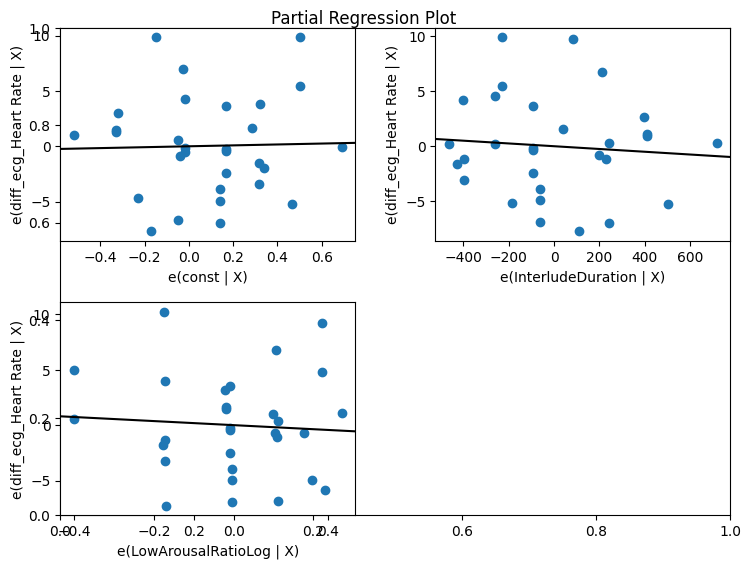

In [26]:
# Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

#### Multiple Linear Regression for ECG

In [27]:
# Print model results 
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

Summary for diff_ecg_Heart Rate ~ const + InterludeDuration + LowArousalRatioLog:
                             OLS Regression Results                            
Dep. Variable:     diff_ecg_Heart Rate   R-squared:                       0.009
Model:                             OLS   Adj. R-squared:                 -0.064
Method:                  Least Squares   F-statistic:                    0.1239
Date:                 Tue, 11 Jun 2024   Prob (F-statistic):              0.884
Time:                         12:23:35   Log-Likelihood:                -87.466
No. Observations:                   30   AIC:                             180.9
Df Residuals:                       27   BIC:                             185.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [28]:
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Beta Coefficients:
 const                 0.410462
InterludeDuration    -0.001258
LowArousalRatioLog   -1.833476
dtype: float64
Confidence Intervals:
                      Lower CI  Upper CI
const               -5.610581  6.431506
InterludeDuration   -0.007094  0.004578
LowArousalRatioLog -12.223409  8.556456


In [29]:
# Uncomment for model with interaction term
formula_w_interaction = derive_formula(model_w_interaction)
print(f"Summary for {formula_w_interaction}:")
print(model_w_interaction.summary())

Summary for diff_ecg_Heart Rate ~ const + InterludeDuration + LowArousalRatioLog + Interaction:
                             OLS Regression Results                            
Dep. Variable:     diff_ecg_Heart Rate   R-squared:                       0.101
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.9789
Date:                 Tue, 11 Jun 2024   Prob (F-statistic):              0.418
Time:                         12:23:35   Log-Likelihood:                -85.997
No. Observations:                   30   AIC:                             180.0
Df Residuals:                       26   BIC:                             185.6
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------

## GSR Peak Amplitude

#### Set variables

In [30]:
# Load data
data = orig_data.copy()
# data.head()

In [31]:
# Set dependent variable
response_var = 'diff_gsr_Peak Amplitude'
# Set predictors
x1, x2 = 'InterludeDuration', 'LowArousalRatioLog'

#### Assumptions checking

##### Preprocess dependents for assumptions 

###### Outlier issues: Remove outlier

In [32]:
# Specify outliers to remove
outlier_ids = [5]
for i in outlier_ids:
    data.drop(i, inplace=True)
# data.head()

###### Normality issues: Log transform

In [33]:
# # Find the minimum value and shift data to be positive
# shifted_data = data[response_var] - data[response_var].min() + 1
# # Log transform
# data[response_var + '_log'] = np.log(shifted_data)

# response_var = response_var + '_log'

##### Initial visualization

###### Dependent variables inspection

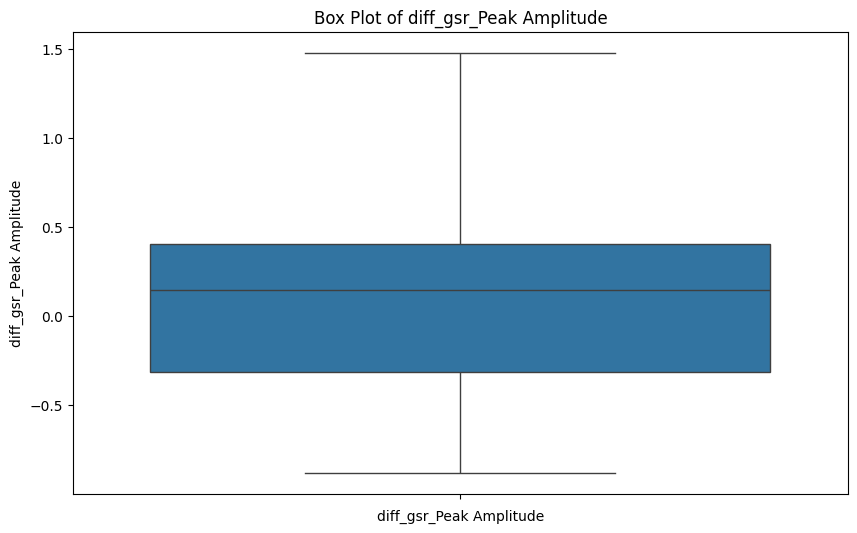

In [34]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[response_var])
plt.title(f'Box Plot of {response_var}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[response_var])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

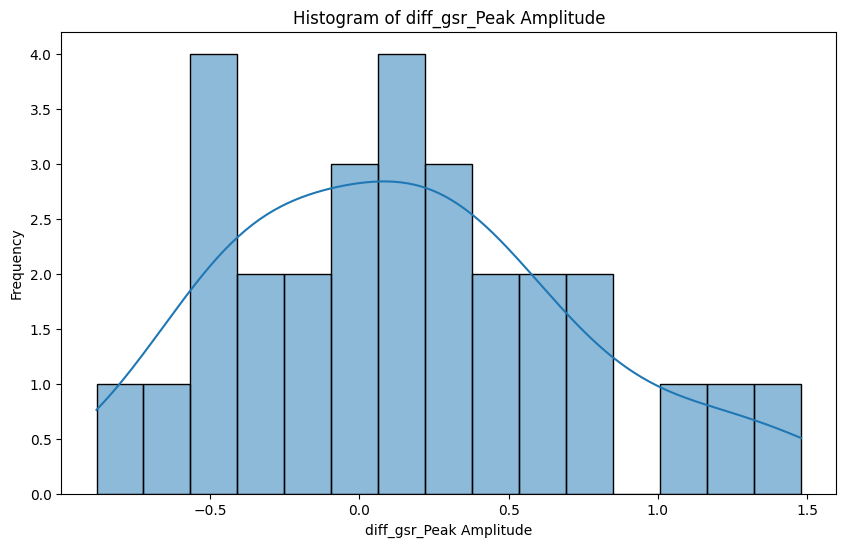

In [35]:
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[response_var], kde=True, bins=15)
plt.xlabel(f'{response_var}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {response_var}')
plt.show()

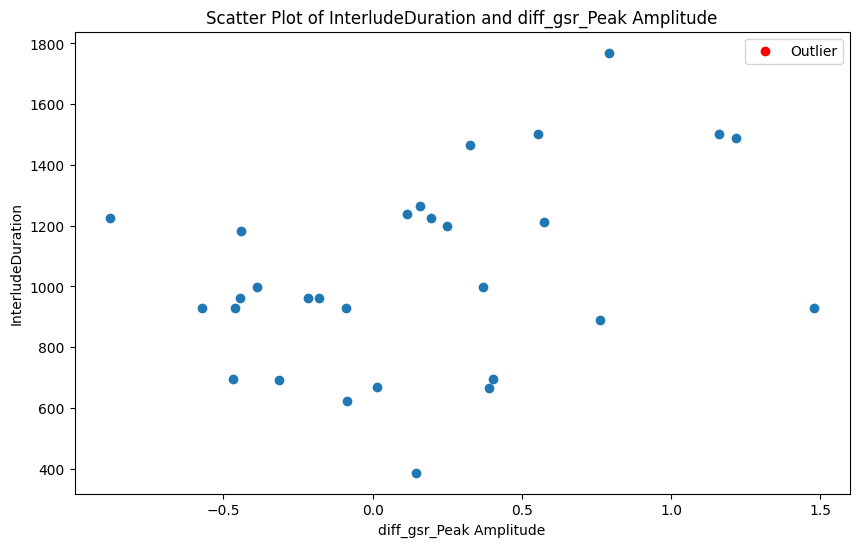

In [36]:
iv = x1
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

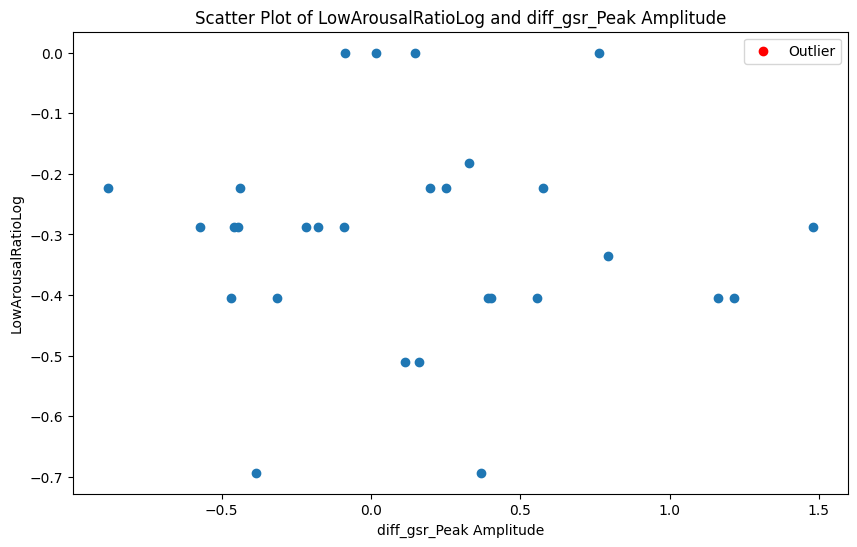

In [37]:
iv = x2
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

##### Residuals analysis

In [38]:
# Select predictors 
X = data[[x1, x2]]

# Define model with interaction term (in case it is needed)
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction[x1] * X_w_interaction[x2]

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models
model_no_interaction = sm.OLS(data[response_var], X).fit()
model_w_interaction = sm.OLS(data[response_var], X_w_interaction).fit()


In [39]:
model = model_no_interaction

###### Outliers

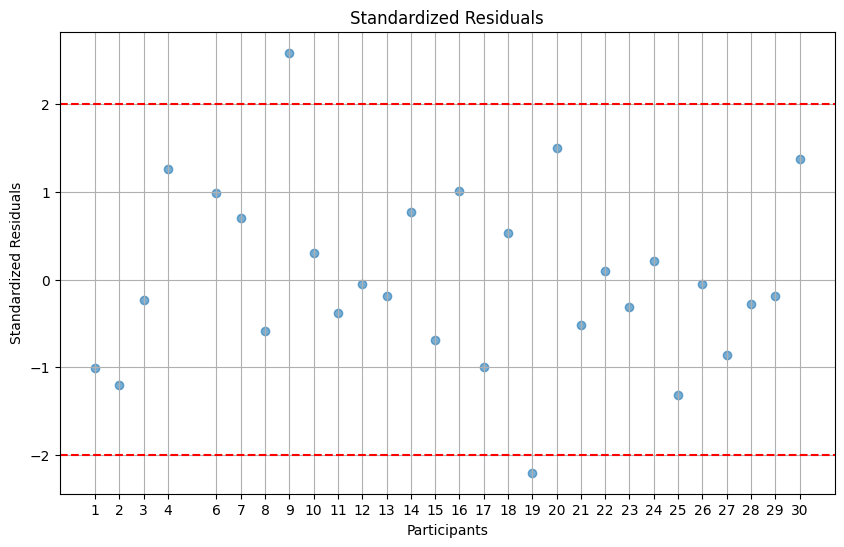

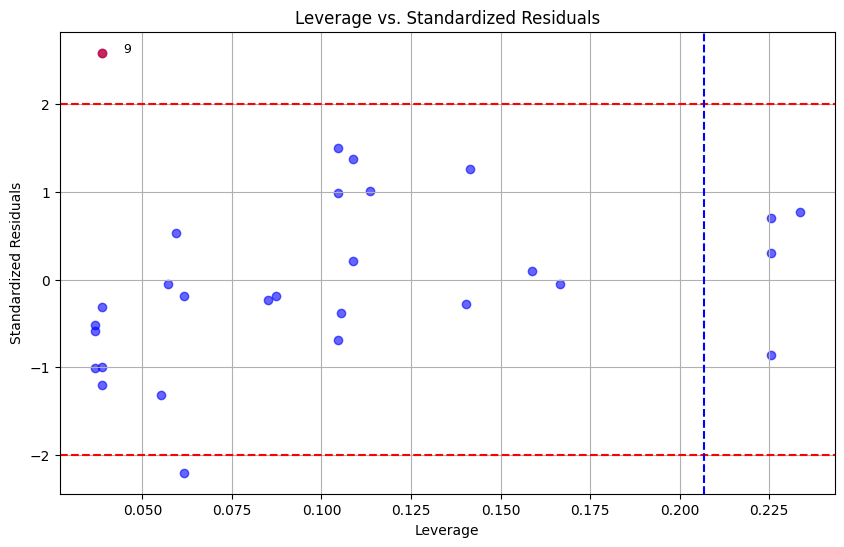

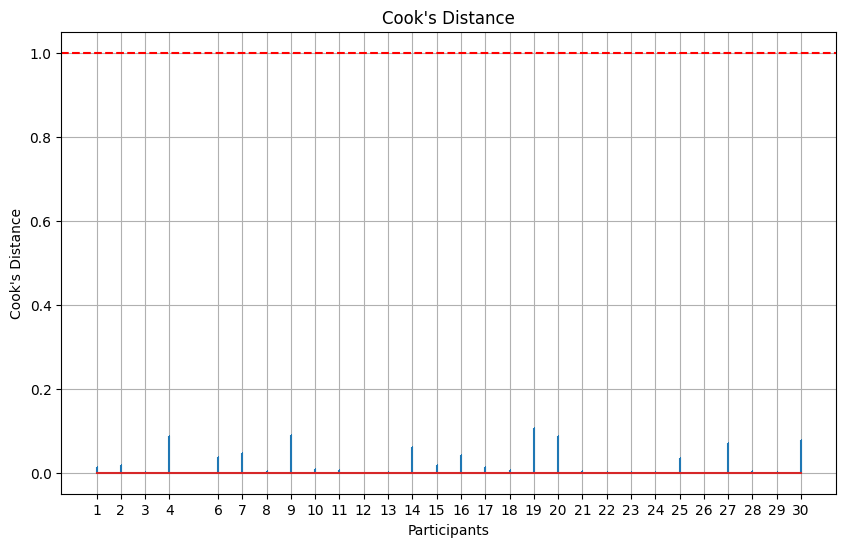

Influential points based on Cook's distance: []


In [40]:
# Standardized Residuals
model.resid_standardized = model.get_influence().resid_studentized_internal

# Leverage
leverage = model.get_influence().hat_matrix_diag

# Cook's Distance
cooks_d = model.get_influence().cooks_distance[0]

# Plot 1
# Plot Standardized Residuals
plt.figure(figsize=(10, 6))
plt.scatter(data.index, model.resid_standardized, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals')
plt.grid(True)
plt.show()

# Plot 2
# Identify outliers (to viually mark)
outlier_mask = abs(model.resid_standardized) > 2.5 # between the 2 and 3 conventions
outlier_indices = data.index[outlier_mask] 

# Plot Leverage vs. Standardized Residuals
plt.figure(figsize=(10, 6))
# Mark outliers using red
plt.scatter(leverage, model.resid_standardized, alpha=0.6, color='blue')  
plt.scatter(leverage[outlier_mask], model.resid_standardized[outlier_mask], alpha=0.6, color='red')  
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axvline(2 * (len(model.params)) / len(model.resid), color='blue', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs. Standardized Residuals')

# Annotate outlier with particiant index 
for index, lev, res in zip(outlier_indices, leverage[outlier_mask], model.resid_standardized[outlier_mask]):
    plt.text(lev+0.008, res, str(index), fontsize=9, ha='right')

plt.grid(True)
plt.show()

# Plot 3
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(data.index, cooks_d, markerfmt=",")
plt.axhline(1, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.grid(True)
plt.show()

# Identify points with high Cook's distance
influential_points = np.where(cooks_d > 1)[0]
print(f"Influential points based on Cook's distance: {influential_points}")



###### Normality

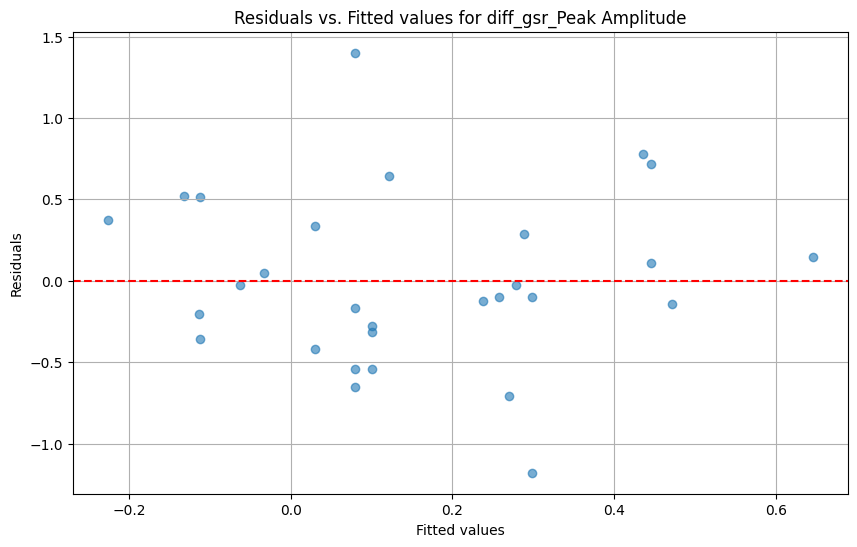

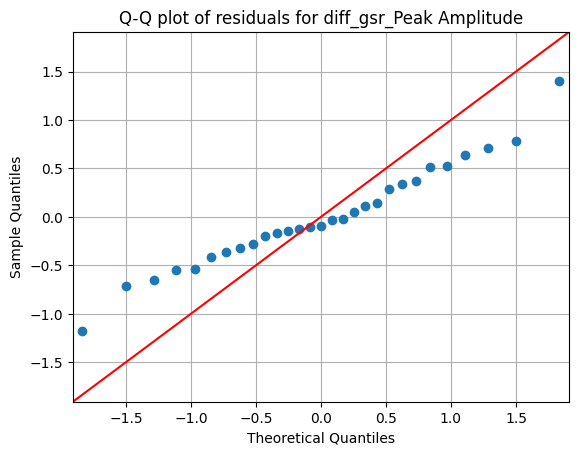

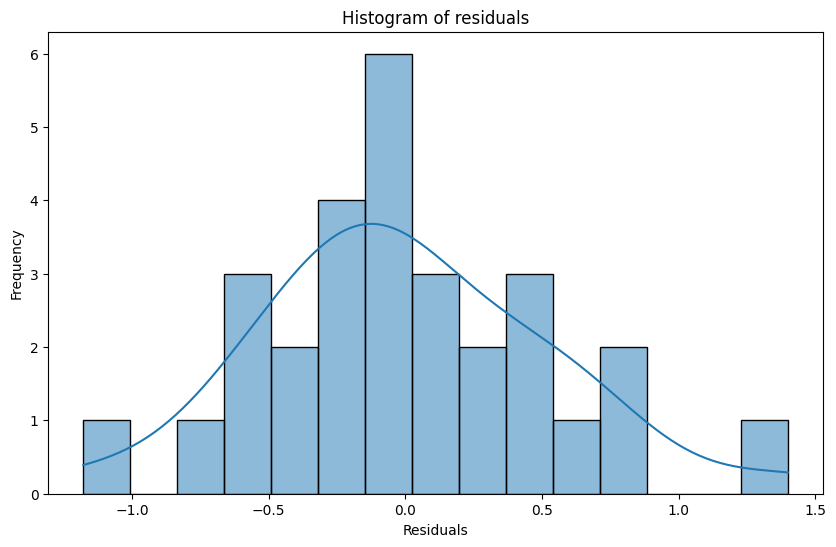

Shapiro-Wilk test: ShapiroResult(statistic=0.9821847677230835, pvalue=0.8898059725761414)
Jarque-Bera test: SignificanceResult(statistic=0.8509652073583576, pvalue=0.6534543495475162)


In [41]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Fitted values for {response_var}')
plt.grid(True)
plt.show()

# Q-Q plot for residuals
sm.qqplot(model.resid, line='45')
plt.title(f'Q-Q plot of residuals for {response_var}')
plt.grid(True)
plt.show()

# Create histogram 
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True, bins=15)
plt.xlabel(f'Residuals')
plt.ylabel('Frequency')
plt.title(f'Histogram of residuals')
plt.show()

# Additional tests

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

###### Independence of residuals

In [42]:
# Durbin-Watson test for independence
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.3677552086908094


###### Homoscedasticity

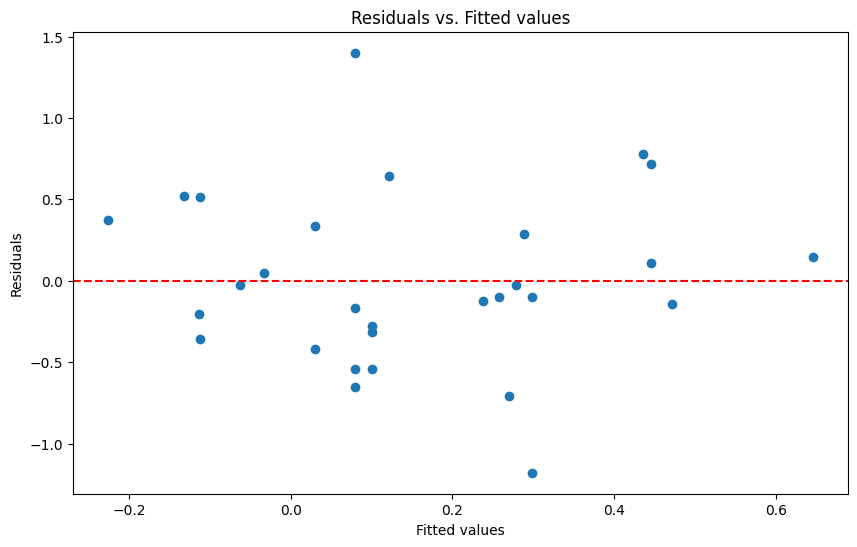

{'LM Statistic': 0.1310647440320576, 'LM-Test p-value': 0.9365687276510216, 'F-Statistic': 0.05901990001742468, 'F-Test p-value': 0.9428139334874512}


In [43]:
# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

###### Multicolinearity

In [44]:
# Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

             Variable        VIF
0               const  12.547963
1   InterludeDuration   1.085799
2  LowArousalRatioLog   1.085799


###### Linearity

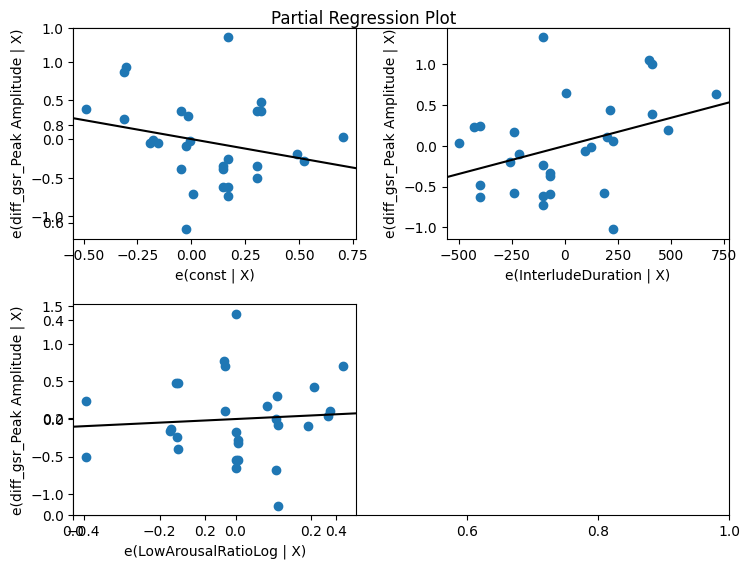

In [45]:
# Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

#### Multiple Linear Regression for GSR

In [46]:
# Print model results 
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

Summary for diff_gsr_Peak Amplitude ~ const + InterludeDuration + LowArousalRatioLog:
                               OLS Regression Results                              
Dep. Variable:     diff_gsr_Peak Amplitude   R-squared:                       0.139
Model:                                 OLS   Adj. R-squared:                  0.073
Method:                      Least Squares   F-statistic:                     2.106
Date:                     Tue, 11 Jun 2024   Prob (F-statistic):              0.142
Time:                             12:23:39   Log-Likelihood:                -22.320
No. Observations:                       29   AIC:                             50.64
Df Residuals:                           26   BIC:                             54.74
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025

In [47]:
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Beta Coefficients:
 const                -0.492197
InterludeDuration     0.000688
LowArousalRatioLog    0.238649
dtype: float64
Confidence Intervals:
                     Lower CI  Upper CI
const              -1.238195  0.253800
InterludeDuration  -0.000004  0.001381
LowArousalRatioLog -1.020849  1.498146


In [48]:
# # Uncomment for model with interaction term
# formula_w_interaction = derive_formula(model_w_interaction)
# print(f"Summary for {formula_w_interaction}:")
# print(model_w_interaction.summary())

## Check Multivariate assumptions

In [49]:
# Dependent variables
y_1 = 'diff_ecg_Heart Rate'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"
x2 = "LowArousalRatioLog"


In [50]:
# Keep relevant columns
relevant_columns = [x1, x2, y_1, y_2]
mvar_data = data[relevant_columns]


###### Linearity

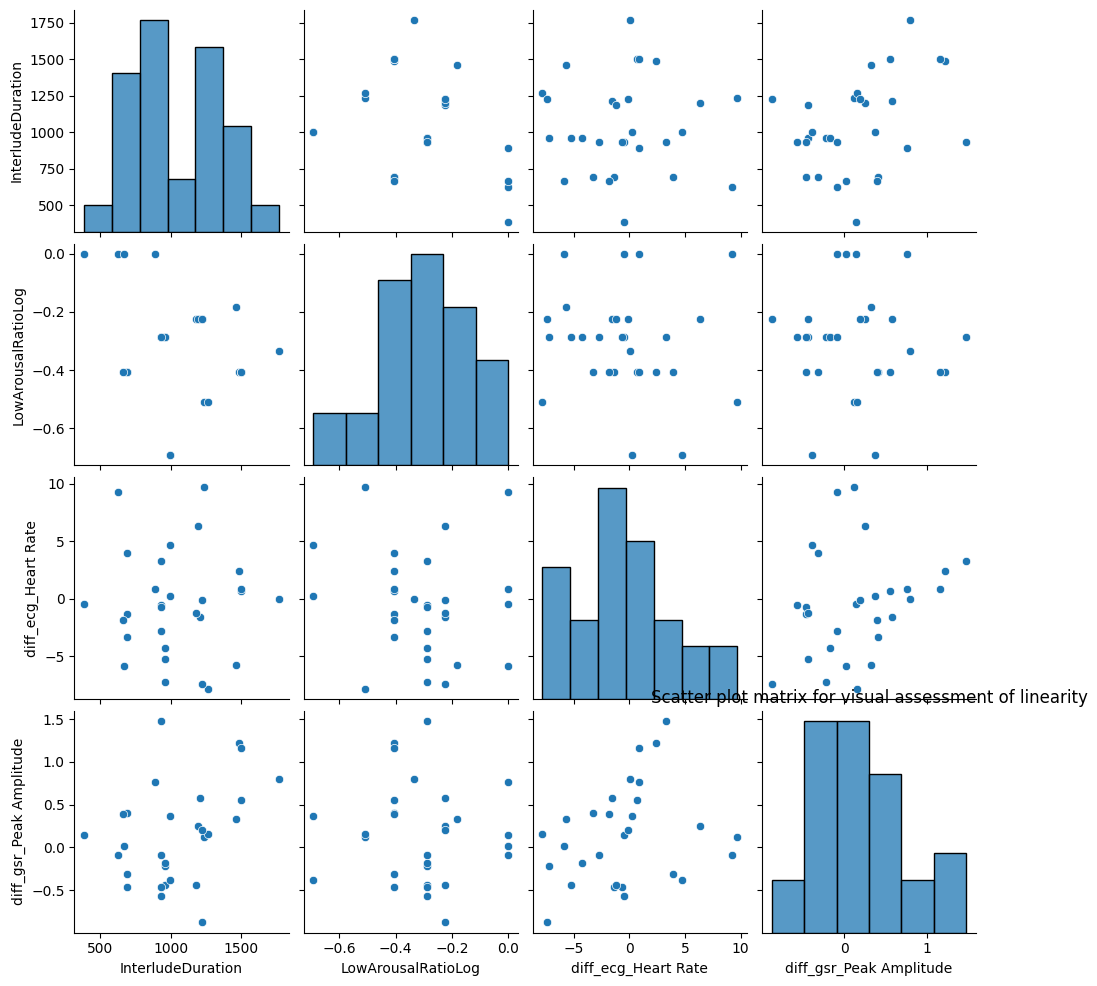

In [51]:
# Scatter plot matrix
sns.pairplot(mvar_data)
plt.title('Scatter plot matrix for visual assessment of linearity')
plt.show()

##### Residual analysis

In [52]:
# Fit linear models
X = sm.add_constant(data[x1])  
model1 = sm.OLS(data[y_1], X).fit()
model2 = sm.OLS(data[y_2], X).fit()

# Collect residuals
residuals = pd.DataFrame({
    f'{y_1}': model1.resid,
    f'{y_2}': model2.resid
})

###### Normality

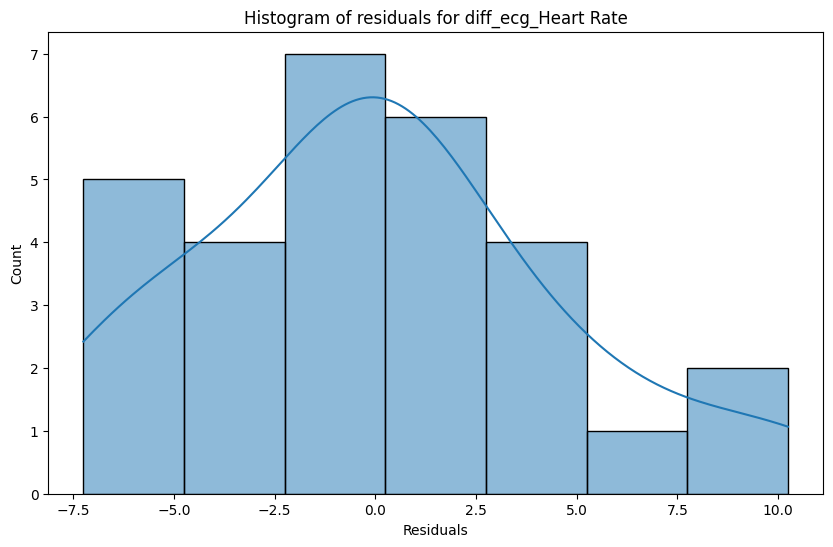

Shapiro-Wilk test for diff_ecg_Heart Rate: ShapiroResult(statistic=0.9603201150894165, pvalue=0.3347550332546234)


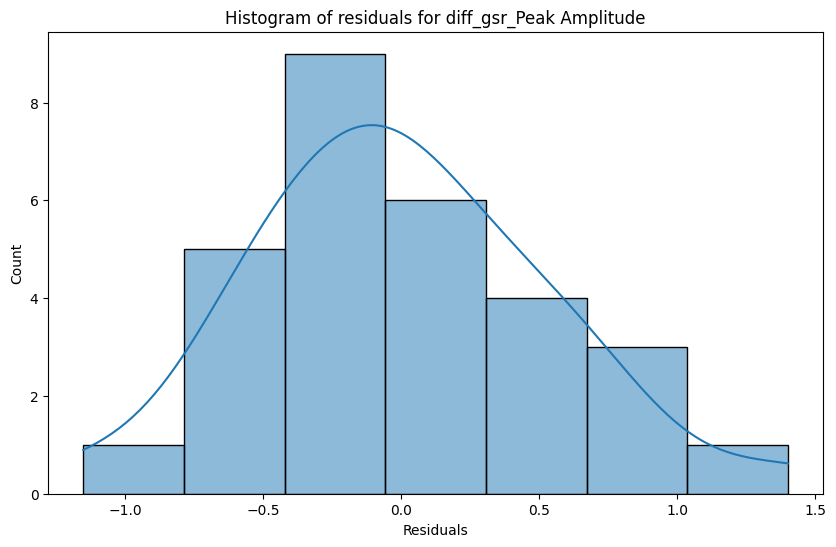

Shapiro-Wilk test for diff_gsr_Peak Amplitude: ShapiroResult(statistic=0.9683353900909424, pvalue=0.515460193157196)

Multivariate normality:
HZResults(hz=0.6562293623143798, pval=0.12623119240213615, normal=True)


In [53]:
# Plot residuals for normality
for var, resid in residuals.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(resid, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Histogram of residuals for {var}')
    plt.show()

    # Get Shapiro-Wilk test for each dependent 
    shapiro_test = shapiro(mvar_data[var])
    print(f'Shapiro-Wilk test for {var}: {shapiro_test}')

# Perform Henze-Zirkler multivariate normality test
data_to_test = data[[y_1, y_2]]

mult_norm_result = pg.multivariate_normality(data_to_test, alpha=0.05)
print("\nMultivariate normality:")
print(mult_norm_result)


###### Multivariate outliers

In [54]:
# Find multivariate outliers using Mahalanobis distance
mean_vector = residuals.mean(axis=0)
cov_matrix = np.cov(residuals.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

residuals_w_distance = residuals.copy()
# Apply Mahalanobis distance calculation for each row
residuals_w_distance['mahalanobis_distance'] = residuals.apply(
    lambda row: mahalanobis(row, mean_vector, inv_cov_matrix), axis=1
)

# Critical value for alpha = 0.01 (convention)
critical_value = chi2.ppf(0.99, df=len(residuals.columns))  
assert len(residuals.columns) == 2

# Identify outliers

residuals_w_distance['outlier'] = residuals_w_distance['mahalanobis_distance'] > critical_value
outliers = residuals_w_distance[residuals_w_distance['outlier']]
print(outliers if len(outliers) > 0 else 'No multivariate outliers.')


No multivariate outliers.


###### Homoscedasticity

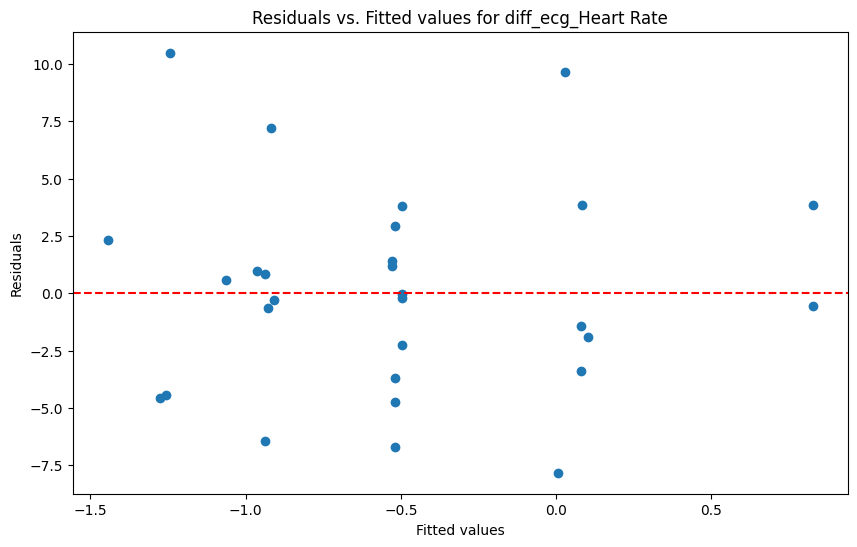

Breusch-Pagan test for diff_ecg_Heart Rate: {'LM Statistic': 0.24632446362694738, 'LM-Test p-value': 0.8841202184991644, 'F-Statistic': 0.11136725887789709, 'F-Test p-value': 0.8950345659991973}


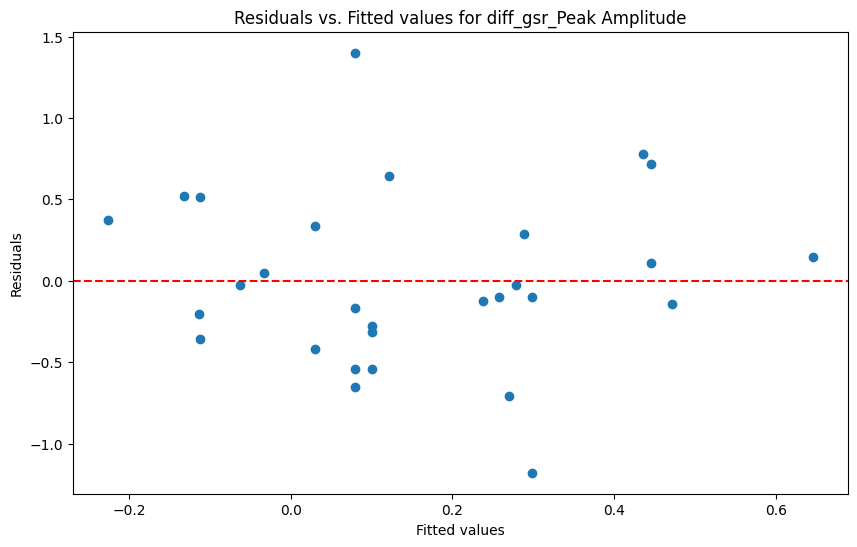

Breusch-Pagan test for diff_gsr_Peak Amplitude: {'LM Statistic': 0.1310647440320576, 'LM-Test p-value': 0.9365687276510216, 'F-Statistic': 0.05901990001742468, 'F-Test p-value': 0.9428139334874512}


In [55]:
# Plot and Breusch-Pagan test

# Fit OLS models for each dependent variable to get residuals
X = mvar_data[[x1, x2]]
X = sm.add_constant(X)  

residuals = {}
for var in dependent_vars:
    model = sm.OLS(mvar_data[var], X).fit()
    residuals[var] = model.resid

    # Plot residuals vs. fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for {var}')
    plt.show()

    # Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(f'Breusch-Pagan test for {var}: {dict(zip(labels, bp_test))}')



## Model fitting and evaluation

#### Original data

In [56]:
data = orig_data.copy()
use_transformed = False

##### No interaction term

In [57]:
# Dependent variables
y_1 = 'diff_ecg_Heart Rate'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"
x2 = "LowArousalRatioLog"

# Keep relevant columns
relevant_columns = [x1, x2, y_1, y_2]
mvar_data = data[relevant_columns]


In [58]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q(f"{x1}") + Q(f"{x2}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8529 2.0000 26.0000  2.2428 0.1263
           Pillai's trace 0.1471 2.0000 26.0000  2.2428 0.1263
   Hotelling-Lawley trace 0.1725 2.0000 26.0000  2.2428 0.1263
      Roy's greatest root 0.1725 2.0000 26.0000  2.2428 0.1263
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
  Q(f"InterludeDuration") Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8311 2.0000 26.0000  2.6428 0.0902
           Pillai's trace 0.1689 2.0000 26.0000  2.6428 0.0902
   Hotellin

##### With interaction term

In [59]:
# Dependent variables
y_1 = 'diff_ecg_Heart Rate'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"
x2 = "LowArousalRatioLog"
x_int = "Interaction"

data[x_int] = data[x1] * data[x2]

# Keep relevant columns
relevant_columns = [x1, x2, x_int, y_1, y_2]
mvar_data = data[relevant_columns]


In [60]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}") + Q("{x2}") + Q("{x_int}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9052 2.0000 25.0000  1.3087 0.2880
          Pillai's trace 0.0948 2.0000 25.0000  1.3087 0.2880
  Hotelling-Lawley trace 0.1047 2.0000 25.0000  1.3087 0.2880
     Roy's greatest root 0.1047 2.0000 25.0000  1.3087 0.2880
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
  Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8905 2.0000 25.0000  1.5370 0.2347
          Pillai's trace 0.1095 2.0000 25.0000  1.5370 0.2347
  Hotelling-Lawley trace 0

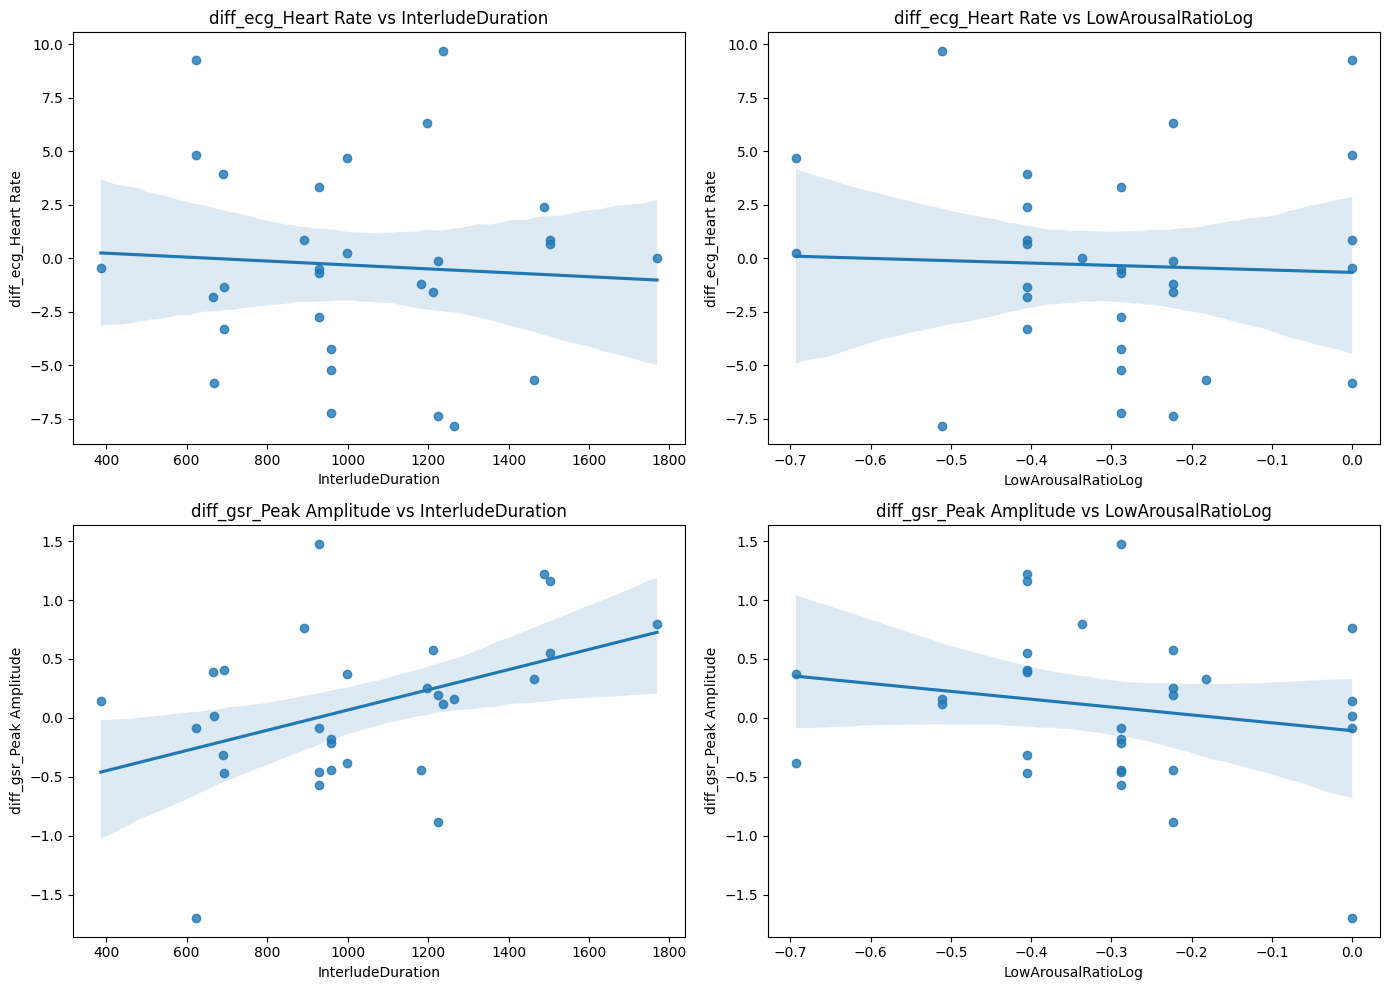

In [61]:
# Plot multivariate data with reg lines
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.regplot(x=x1, y=y_1, data=mvar_data, ax=axes[0, 0])
axes[0, 0].set_title(f'{y_1} vs {x1}')

sns.regplot(x=x2, y=y_1, data=mvar_data, ax=axes[0, 1])
axes[0, 1].set_title(f'{y_1} vs {x2}')

sns.regplot(x=x1, y=y_2, data=mvar_data, ax=axes[1, 0])
axes[1, 0].set_title(f'{y_2} vs {x1}')

sns.regplot(x=x2, y=y_2, data=mvar_data, ax=axes[1, 1])
axes[1, 1].set_title(f'{y_2} vs {x2}')

plt.tight_layout()
plt.show()

#### Original data (+no univariate outlier)

In [62]:
data = orig_data.copy()
# Scale values
use_transformed = False

In [63]:
# Specify outliers to remove
outlier_id = 5 
outlier_ids = [outlier_id]
for i in outlier_ids:
    data.drop(i, inplace=True)
# data.head()

##### No interaction term

In [64]:
# Dependent variables
y_1 = 'diff_ecg_Heart Rate'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"
x2 = "LowArousalRatioLog"

# Keep relevant columns
relevant_columns = [x1, x2, y_1, y_2]
mvar_data = data[relevant_columns]


In [65]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q(f"{x1}") + Q(f"{x2}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.9333 2.0000 25.0000  0.8939 0.4217
           Pillai's trace 0.0667 2.0000 25.0000  0.8939 0.4217
   Hotelling-Lawley trace 0.0715 2.0000 25.0000  0.8939 0.4217
      Roy's greatest root 0.0715 2.0000 25.0000  0.8939 0.4217
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
  Q(f"InterludeDuration") Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8399 2.0000 25.0000  2.3823 0.1130
           Pillai's trace 0.1601 2.0000 25.0000  2.3823 0.1130
   Hotellin

##### With interaction term

In [66]:
# Dependent variables
y_1 = 'diff_ecg_Heart Rate'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"
x2 = "LowArousalRatioLog"
x_int = "Interaction"

data[x_int] = data[x1] * data[x2]

# Keep relevant columns
relevant_columns = [x1, x2, x_int, y_1, y_2]
mvar_data = data[relevant_columns]


In [67]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}") + Q("{x2}") + Q("{x_int}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9610 2.0000 24.0000  0.4874 0.6202
          Pillai's trace 0.0390 2.0000 24.0000  0.4874 0.6202
  Hotelling-Lawley trace 0.0406 2.0000 24.0000  0.4874 0.6202
     Roy's greatest root 0.0406 2.0000 24.0000  0.4874 0.6202
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
  Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9312 2.0000 24.0000  0.8865 0.4252
          Pillai's trace 0.0688 2.0000 24.0000  0.8865 0.4252
  Hotelling-Lawley trace 0

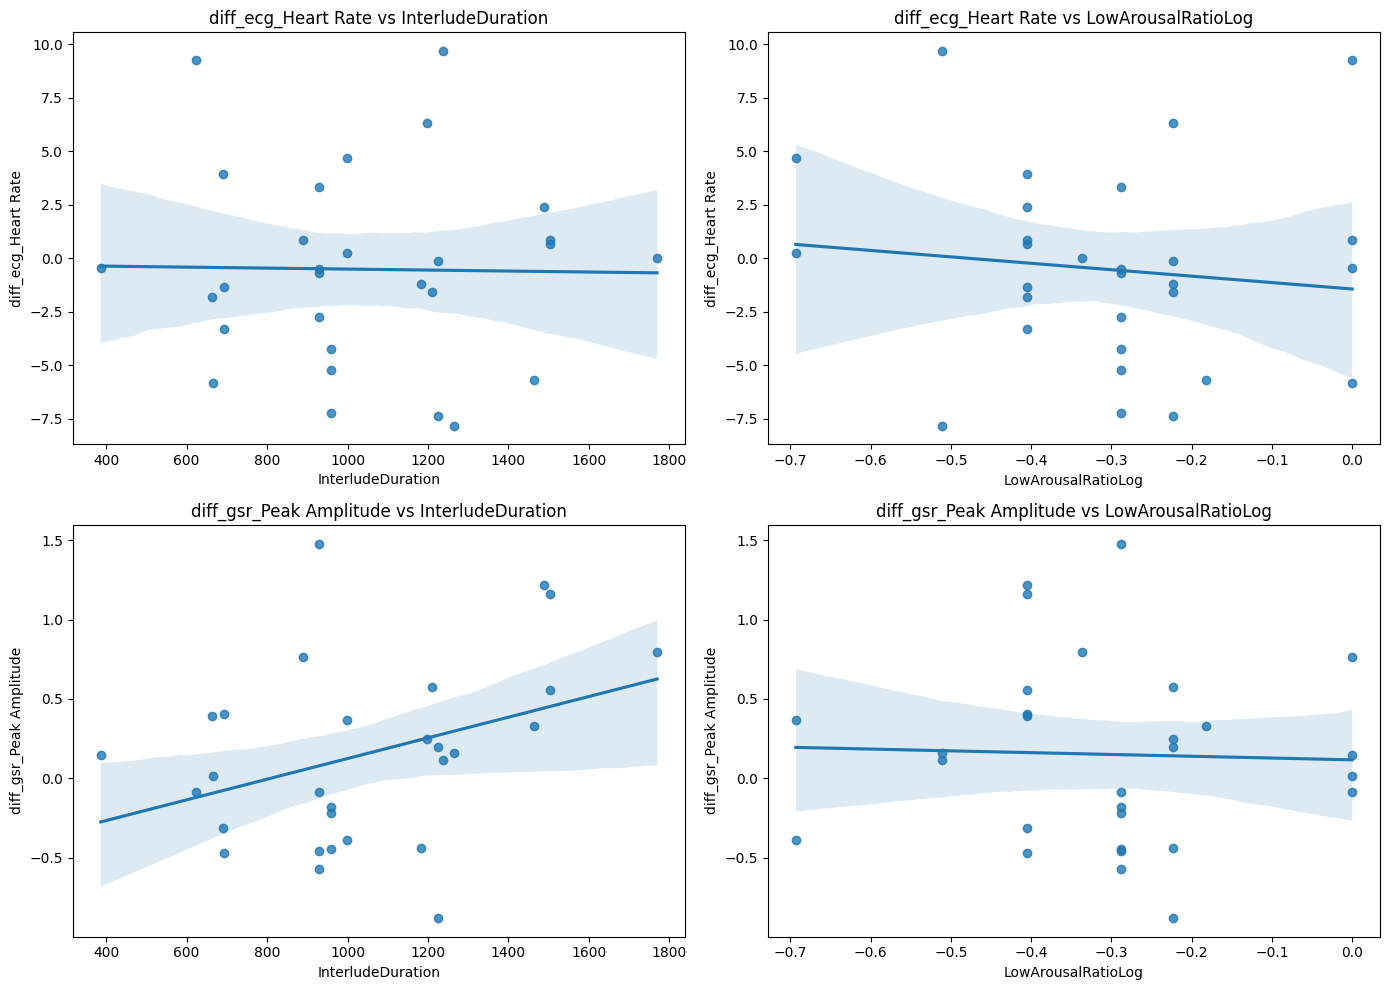

In [68]:
# Plot multivariate data with reg lines
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.regplot(x=x1, y=y_1, data=mvar_data, ax=axes[0, 0])
axes[0, 0].set_title(f'{y_1} vs {x1}')

sns.regplot(x=x2, y=y_1, data=mvar_data, ax=axes[0, 1])
axes[0, 1].set_title(f'{y_1} vs {x2}')

sns.regplot(x=x1, y=y_2, data=mvar_data, ax=axes[1, 0])
axes[1, 0].set_title(f'{y_2} vs {x1}')

sns.regplot(x=x2, y=y_2, data=mvar_data, ax=axes[1, 1])
axes[1, 1].set_title(f'{y_2} vs {x2}')

plt.tight_layout()
plt.show()

# Multiple Linear Regression

## Linear Model for ECG

#### Set variables

In [69]:
# Load data
data = orig_data.copy()
# data.head()

In [70]:
# Set dependent variable
response_var = 'diff_ecg_Heart Rate'
# Set predictors
x1, x2 = 'InterludeDuration', 'LowArousalRatioLog'

#### Assumptions checking

##### Preprocess dependents for assumptions 

###### Outlier issues: Remove outlier

In [71]:
# data = orig_data.copy()
# # data.head()
# # Specify outliers to remove
# outlier_ids = []
# for i in outlier_ids:
#     data.drop(i, inplace=True)
# # data.head()

###### Normality issues: Log transform

In [72]:
# # Find the minimum value and shift data to be positive
# shifted_data = data[response_var] - data[response_var].min() + 1
# # Log transform
# data[response_var + '_log'] = np.log(shifted_data)

# response_var = response_var + '_log'

##### Initial visualization

###### Dependent variables inspection

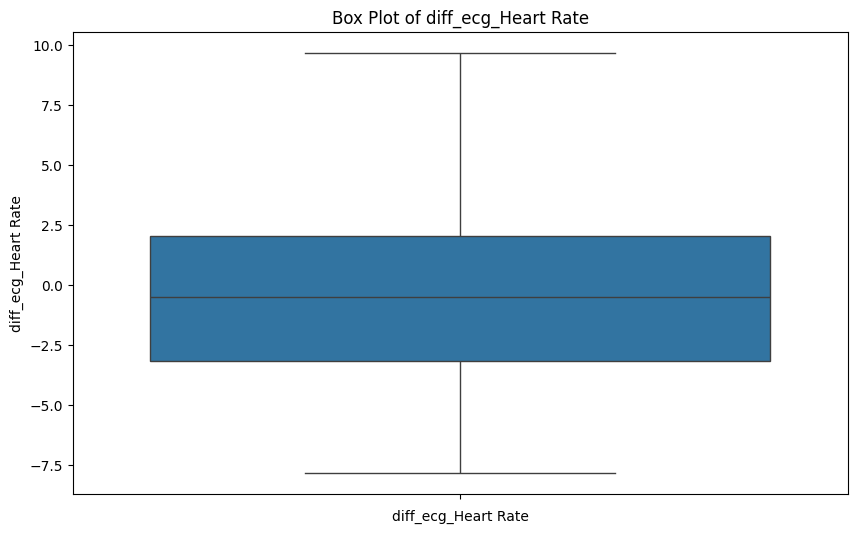

In [73]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[response_var])
plt.title(f'Box Plot of {response_var}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[response_var])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

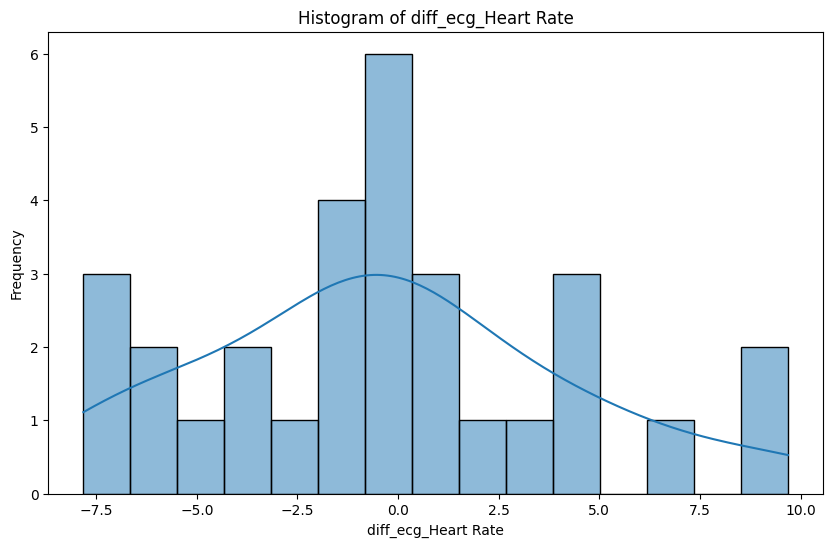

In [74]:
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[response_var], kde=True, bins=15)
plt.xlabel(f'{response_var}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {response_var}')
plt.show()

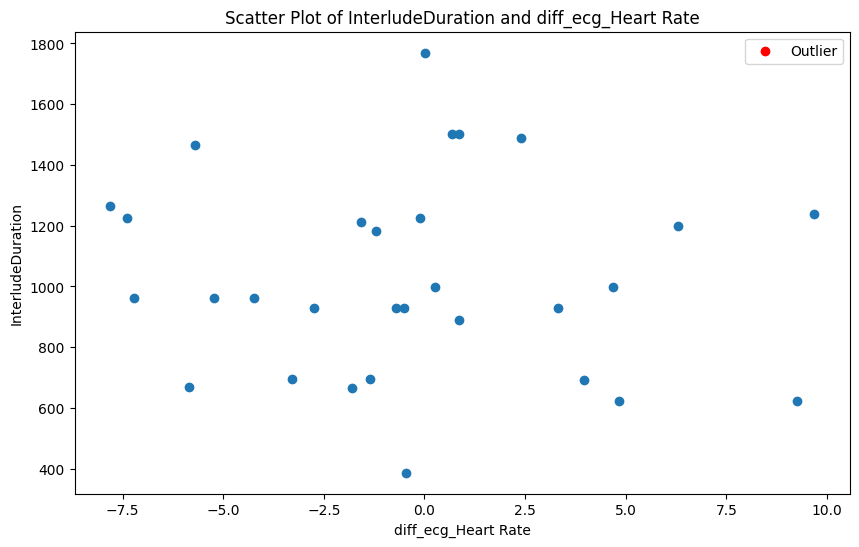

In [75]:
iv = x1
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

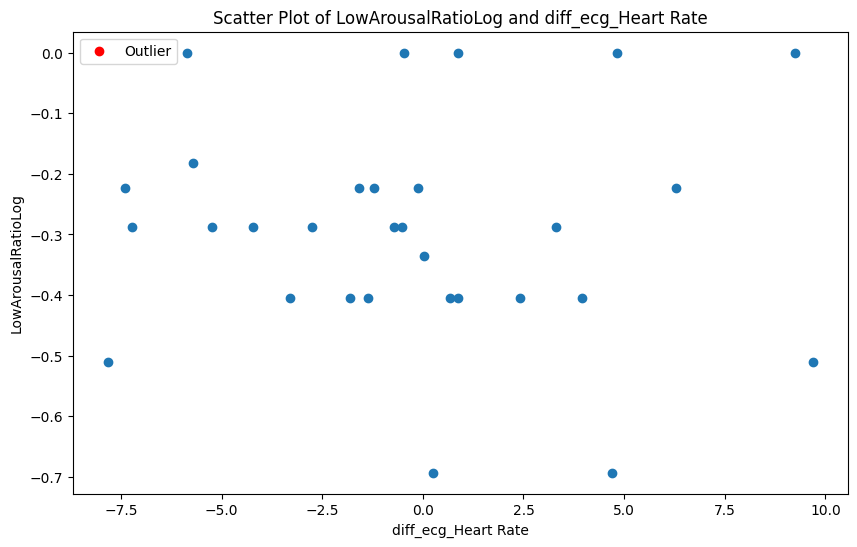

In [76]:
iv = x2
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

###### Independent variables inspection

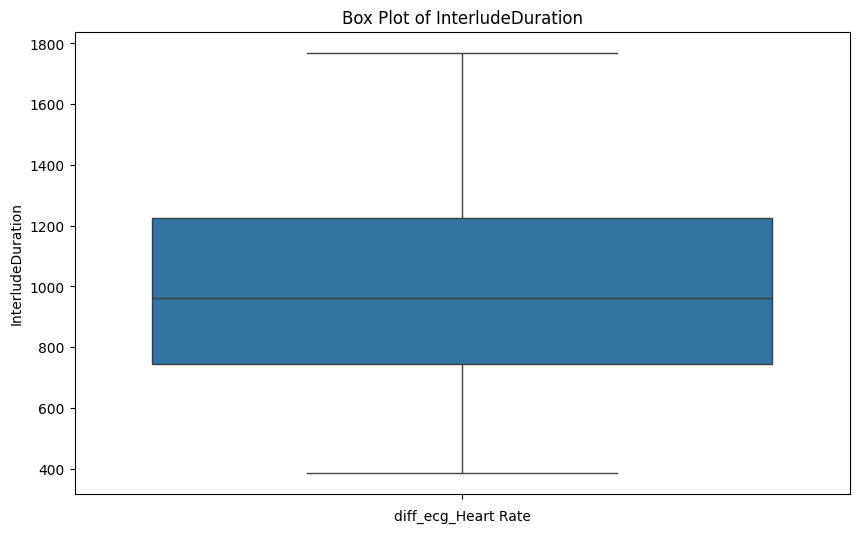

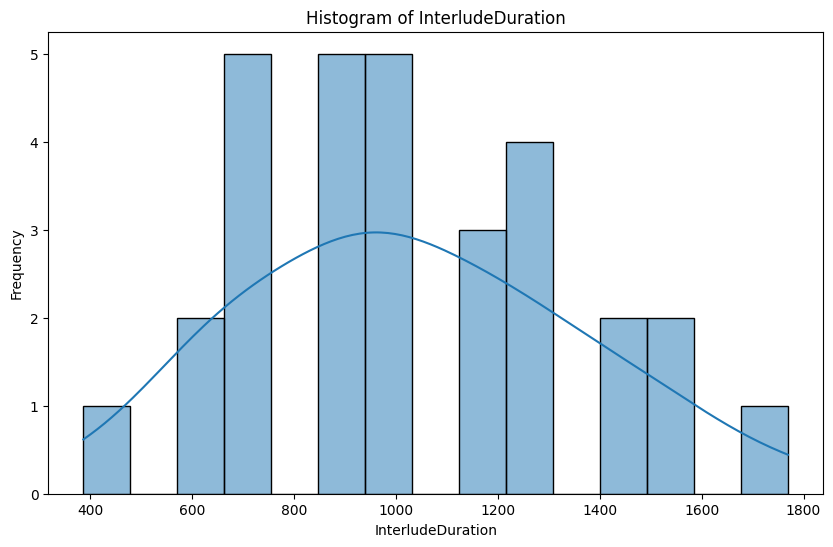

In [77]:
# Check independent variables
x = x1

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[x])
plt.title(f'Box Plot of {x}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[x])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[x], kde=True, bins=15)
plt.xlabel(f'{x}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {x}')
plt.show()

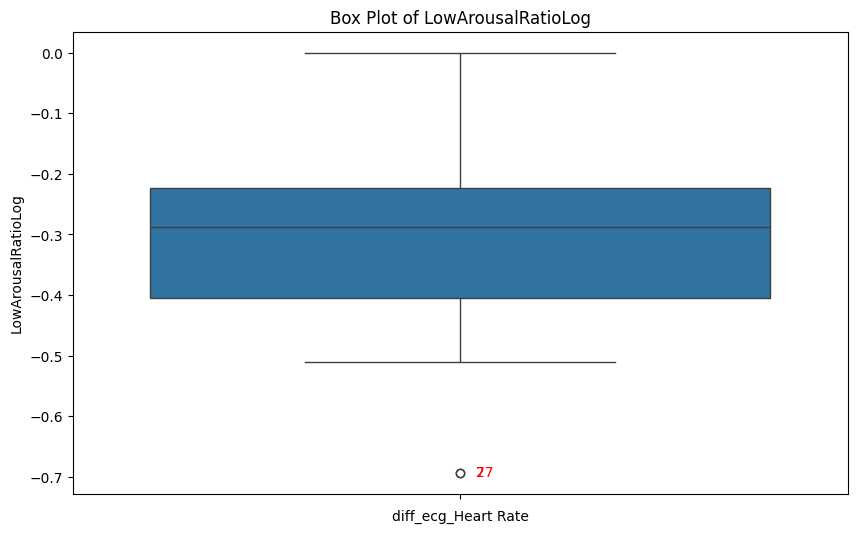

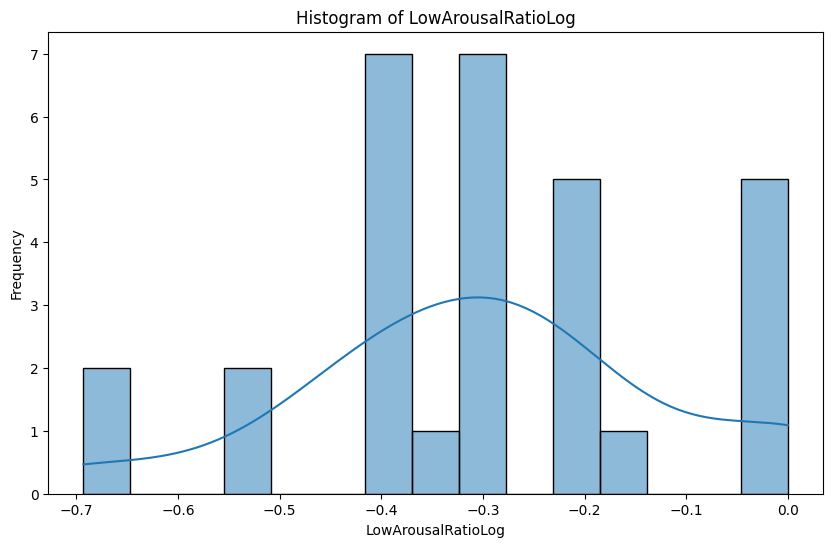

In [78]:
# Check independent variables
x = x2

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[x])
plt.title(f'Box Plot of {x}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[x])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[x], kde=True, bins=15)
plt.xlabel(f'{x}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {x}')
plt.show()

In [79]:
ivs = [x1, x2]  

# Calculate the standard deviation for each independent variable
std_devs = data[ivs].std()

# Check for non-zero variance and print results
print("Standard Deviations of Independent Variables:")
print(std_devs)

# Identify any variables with zero or near-zero variance
near_zero_variance = std_devs[std_devs < 1e-4]  # threshold can be adjusted
if not near_zero_variance.empty:
    print("\nVariables with near-zero variance:")
    print(near_zero_variance)
else:
    print("\nNo variables with near-zero variance detected.")

Standard Deviations of Independent Variables:
InterludeDuration     325.835701
LowArousalRatioLog      0.183010
dtype: float64

No variables with near-zero variance detected.


##### Residuals analysis

In [80]:
# Select predictors 
X = data[[x1, x2]]

# Define model with interaction term (in case it is needed)
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction[x1] * X_w_interaction[x2]

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models
model_no_interaction = sm.OLS(data[response_var], X).fit()
model_w_interaction = sm.OLS(data[response_var], X_w_interaction).fit()


In [81]:
model = model_no_interaction

###### Outliers

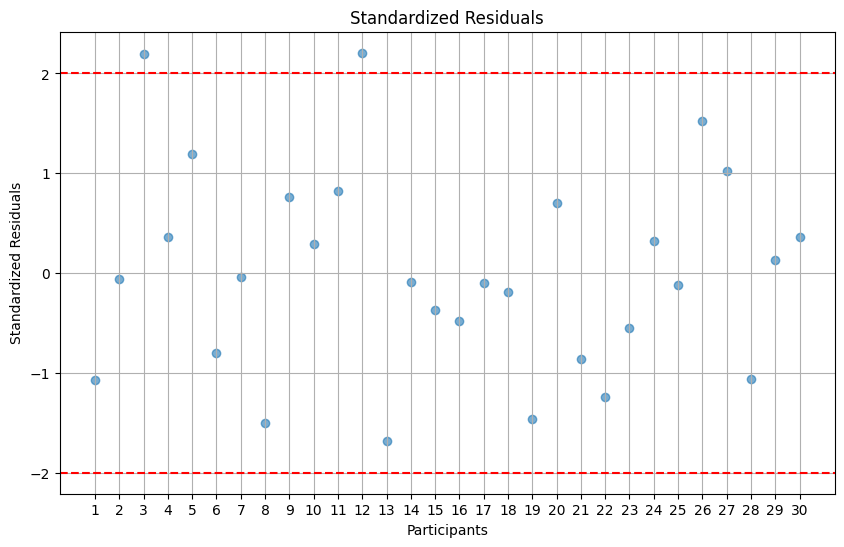

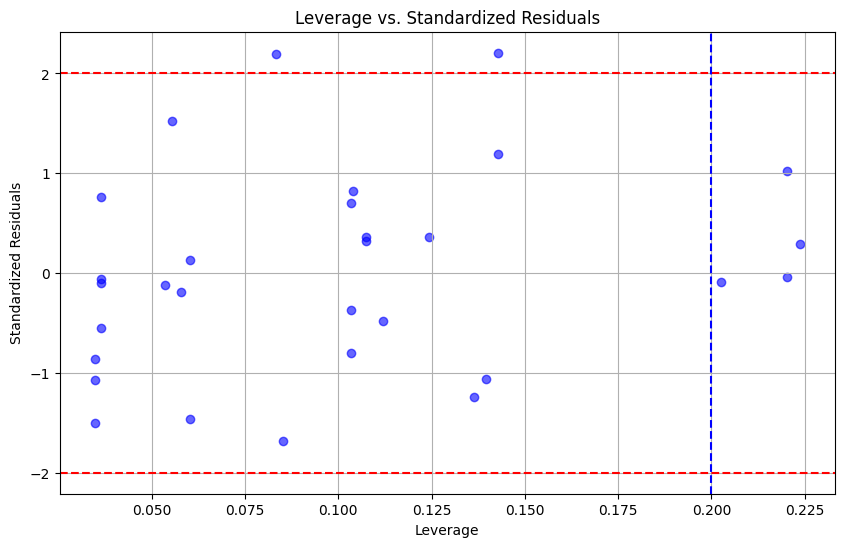

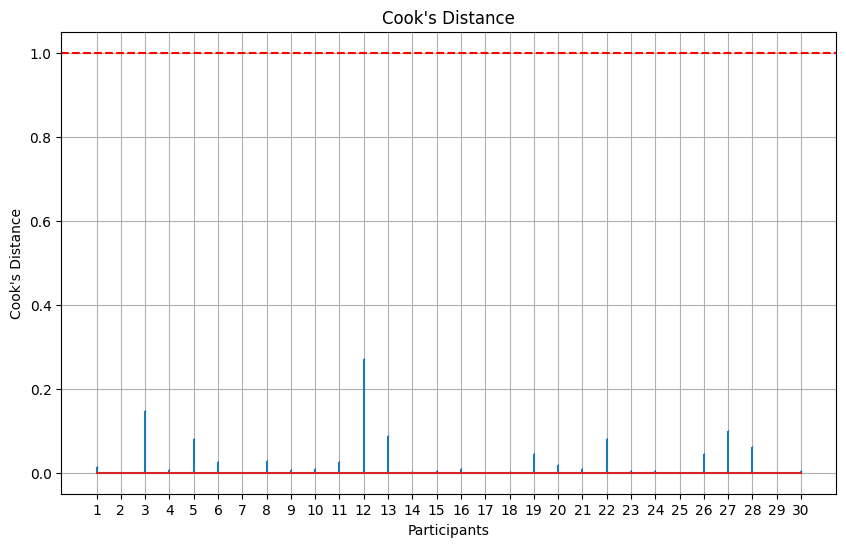

Influential points based on Cook's distance: []


In [82]:
# Standardized Residuals
model.resid_standardized = model.get_influence().resid_studentized_internal

# Leverage
leverage = model.get_influence().hat_matrix_diag

# Cook's Distance
cooks_d = model.get_influence().cooks_distance[0]

# Plot 1
# Plot Standardized Residuals
plt.figure(figsize=(10, 6))
plt.scatter(data.index, model.resid_standardized, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals')
plt.grid(True)
plt.show()

# Plot 2
# Identify outliers (to viually mark)
outlier_mask = abs(model.resid_standardized) > 2.5 # between the 2 and 3 conventions
outlier_indices = data.index[outlier_mask] 

# Plot Leverage vs. Standardized Residuals
plt.figure(figsize=(10, 6))
# Mark outliers using red
plt.scatter(leverage, model.resid_standardized, alpha=0.6, color='blue')  
plt.scatter(leverage[outlier_mask], model.resid_standardized[outlier_mask], alpha=0.6, color='red')  
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axvline(2 * (len(model.params)) / len(model.resid), color='blue', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs. Standardized Residuals')

# Annotate outlier with participant index 
for index, lev, res in zip(outlier_indices, leverage[outlier_mask], model.resid_standardized[outlier_mask]):
    plt.text(lev+0.008, res, str(index), fontsize=9, ha='right')

plt.grid(True)
plt.show()

# Plot 3
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(data.index, cooks_d, markerfmt=",")
plt.axhline(1, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.grid(True)
plt.show()

# Identify points with high Cook's distance
influential_points = np.where(cooks_d > 1)[0]
print(f"Influential points based on Cook's distance: {influential_points}")



###### Normality

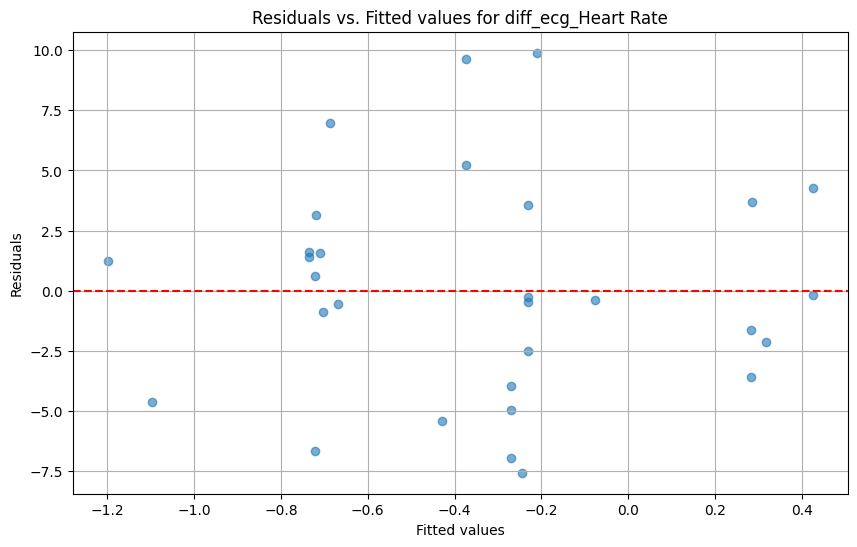

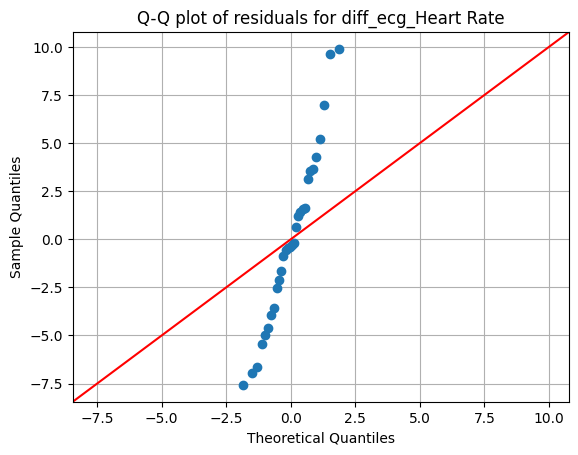

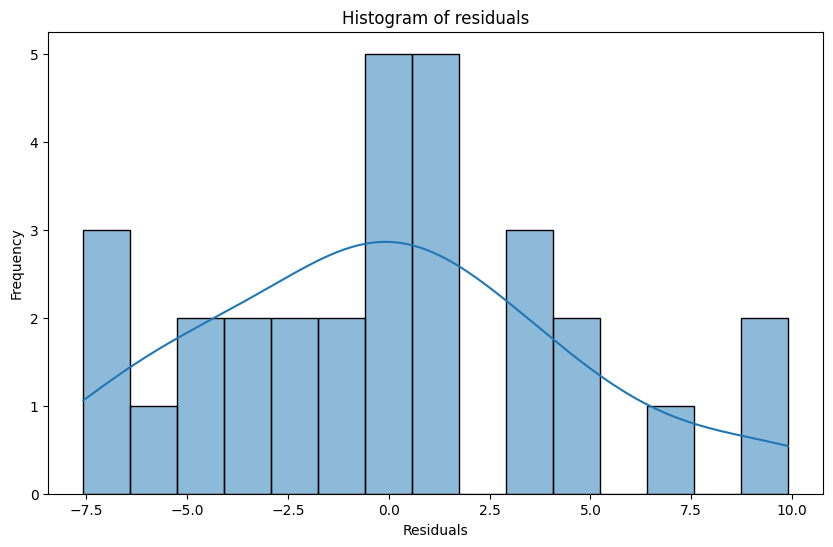

Shapiro-Wilk test: ShapiroResult(statistic=0.9713904857635498, pvalue=0.5778843760490417)
Jarque-Bera test: SignificanceResult(statistic=0.7856672961660937, pvalue=0.6751410492528325)


In [83]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Fitted values for {response_var}')
plt.grid(True)
plt.show()

# Q-Q plot for residuals
sm.qqplot(model.resid, line='45')
plt.title(f'Q-Q plot of residuals for {response_var}')
plt.grid(True)
plt.show()

# Create histogram 
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True, bins=15)
plt.xlabel(f'Residuals')
plt.ylabel('Frequency')
plt.title(f'Histogram of residuals')
plt.show()

# Additional tests

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

###### Independence of residuals

In [84]:
# Durbin-Watson test for independence
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.059233013908885


###### Homoscedasticity

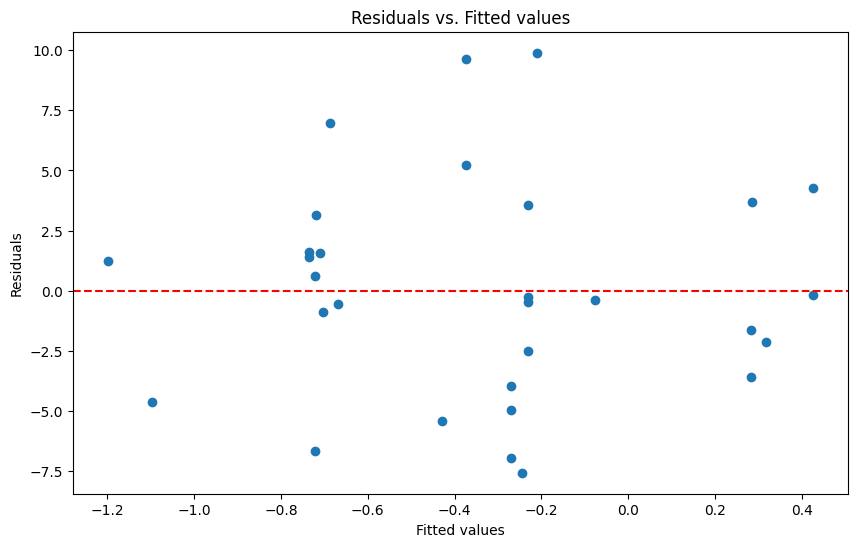

{'LM Statistic': 0.15048044639570102, 'LM-Test p-value': 0.9275206475880711, 'F-Statistic': 0.068057578705539, 'F-Test p-value': 0.9343664212826793}


In [85]:
# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

###### Multicolinearity

In [86]:
# Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

             Variable        VIF
0               const  11.654906
1   InterludeDuration   1.123608
2  LowArousalRatioLog   1.123608


###### Linearity

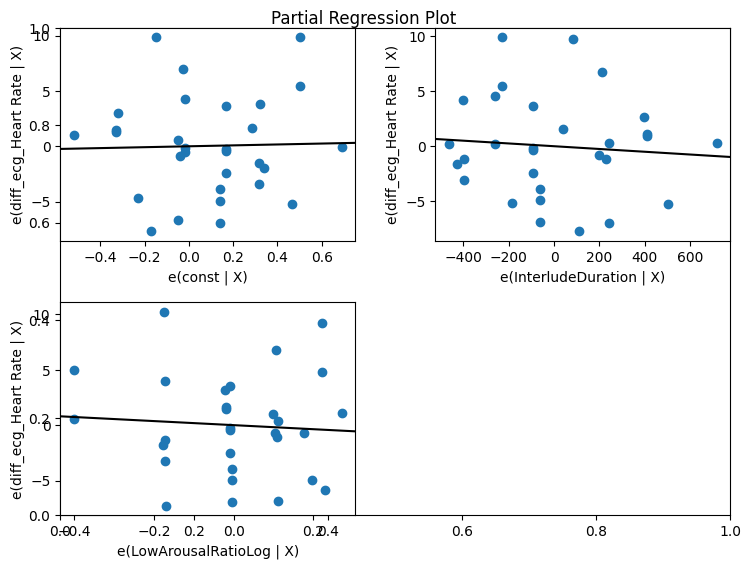

In [87]:
# Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

#### Model fitting and evaluation

In [88]:
# Print model results 
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

Summary for diff_ecg_Heart Rate ~ const + InterludeDuration + LowArousalRatioLog:
                             OLS Regression Results                            
Dep. Variable:     diff_ecg_Heart Rate   R-squared:                       0.009
Model:                             OLS   Adj. R-squared:                 -0.064
Method:                  Least Squares   F-statistic:                    0.1239
Date:                 Tue, 11 Jun 2024   Prob (F-statistic):              0.884
Time:                         12:23:47   Log-Likelihood:                -87.466
No. Observations:                   30   AIC:                             180.9
Df Residuals:                       27   BIC:                             185.1
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [89]:
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Beta Coefficients:
 const                 0.410462
InterludeDuration    -0.001258
LowArousalRatioLog   -1.833476
dtype: float64
Confidence Intervals:
                      Lower CI  Upper CI
const               -5.610581  6.431506
InterludeDuration   -0.007094  0.004578
LowArousalRatioLog -12.223409  8.556456


In [90]:
# # Uncomment for model with interaction term
# formula_w_interaction = derive_formula(model_w_interaction)
# print(f"Summary for {formula_w_interaction}:")
# print(model_w_interaction.summary())

## Linear Model for GSR

#### Set variables

In [91]:
# Load data
data = orig_data.copy()
# data.head()

In [92]:
# Set dependent variable
response_var = 'diff_gsr_Peak Amplitude'
# Set predictors
x1, x2 = 'InterludeDuration', 'LowArousalRatioLog'

#### Assumptions checking

##### Preprocess dependents for assumptions 

###### Outlier issues: Remove outlier

In [93]:
# # Specify outliers to remove
# outlier_ids = [5]
# for i in outlier_ids:
#     data.drop(i, inplace=True)
# # data.head()

###### Normality issues: Log transform

In [94]:
# # Find the minimum value and shift data to be positive
# shifted_data = data[response_var] - data[response_var].min() + 1
# # Log transform
# data[response_var + '_log'] = np.log(shifted_data)

# response_var = response_var + '_log'

##### Initial visualization

###### Dependent variables inspection

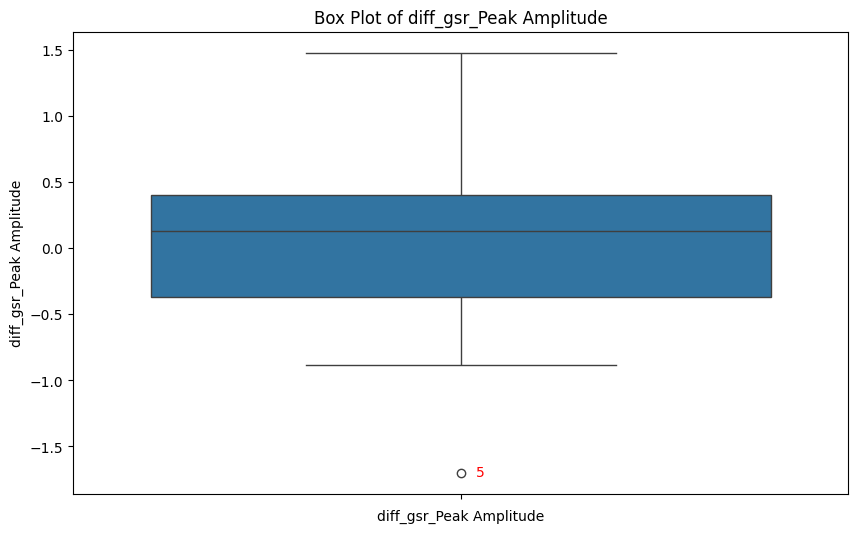

In [95]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[response_var])
plt.title(f'Box Plot of {response_var}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[response_var])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

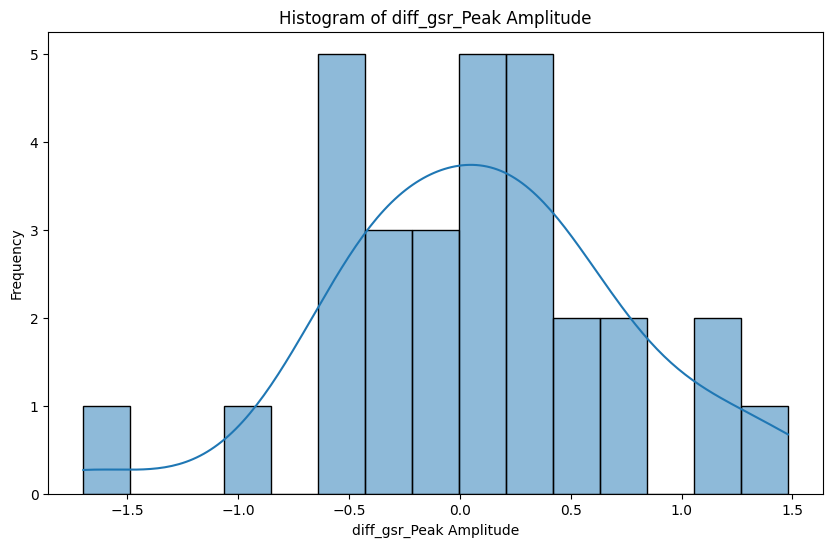

In [96]:
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[response_var], kde=True, bins=15)
plt.xlabel(f'{response_var}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {response_var}')
plt.show()

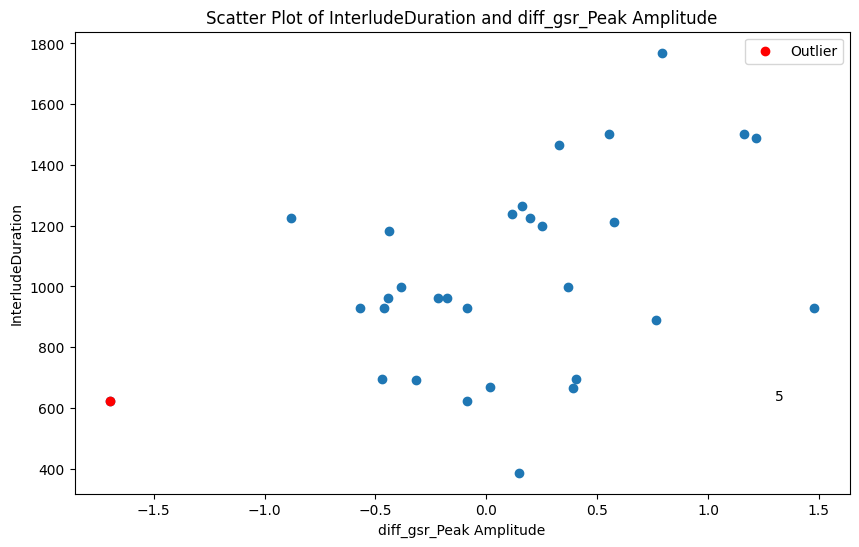

In [97]:
iv = x1
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

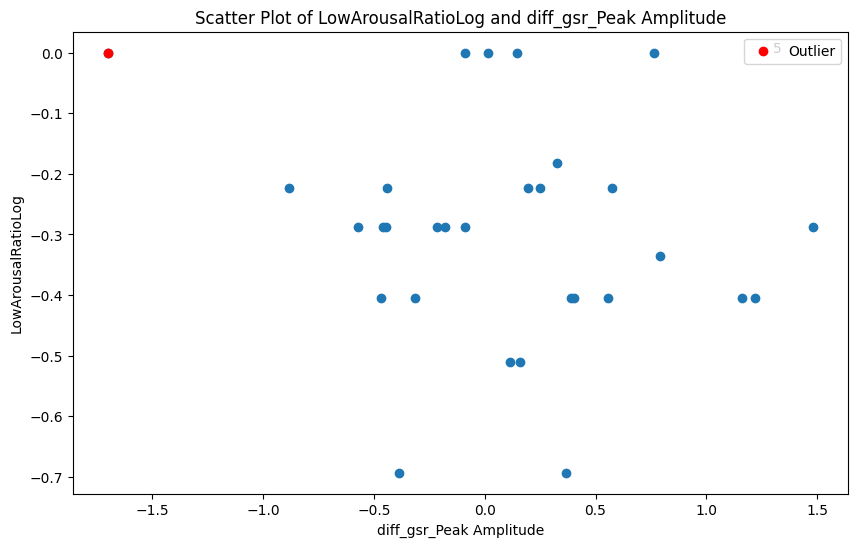

In [98]:
iv = x2
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

###### Independent variables inspection

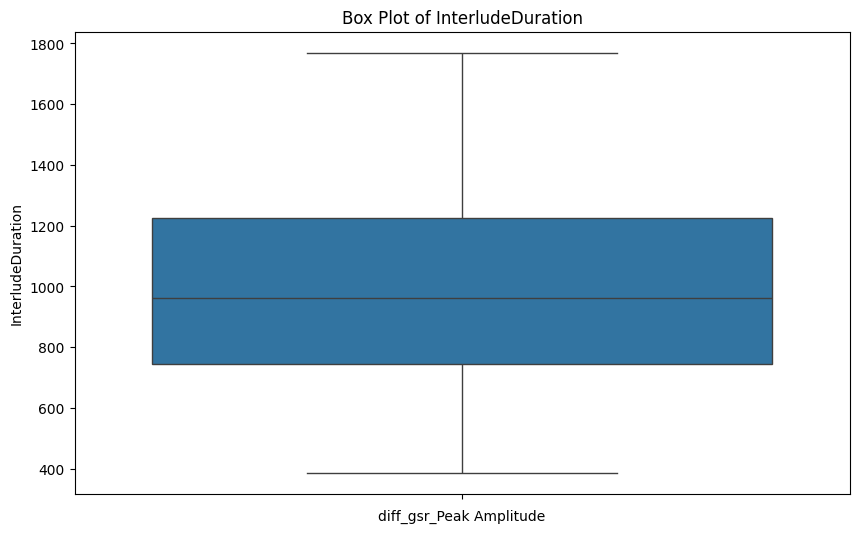

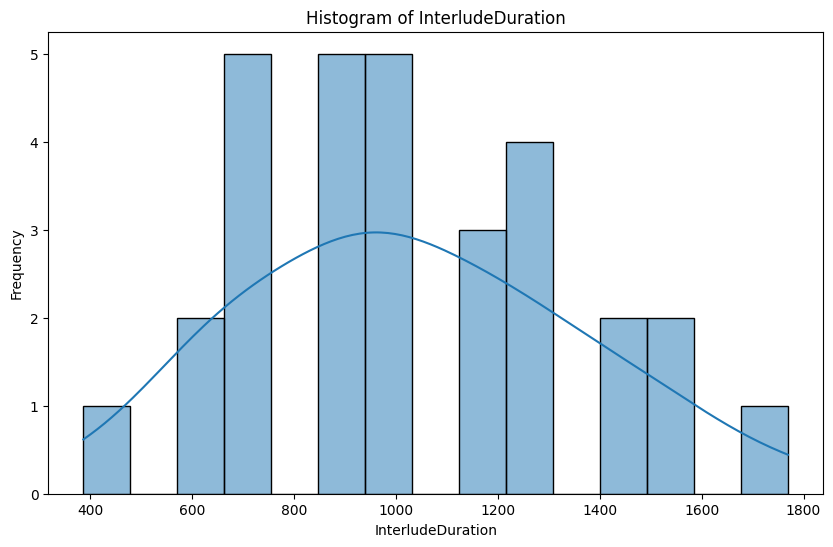

In [99]:
# Check independent variables
x = x1

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[x])
plt.title(f'Box Plot of {x}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[x])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[x], kde=True, bins=15)
plt.xlabel(f'{x}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {x}')
plt.show()

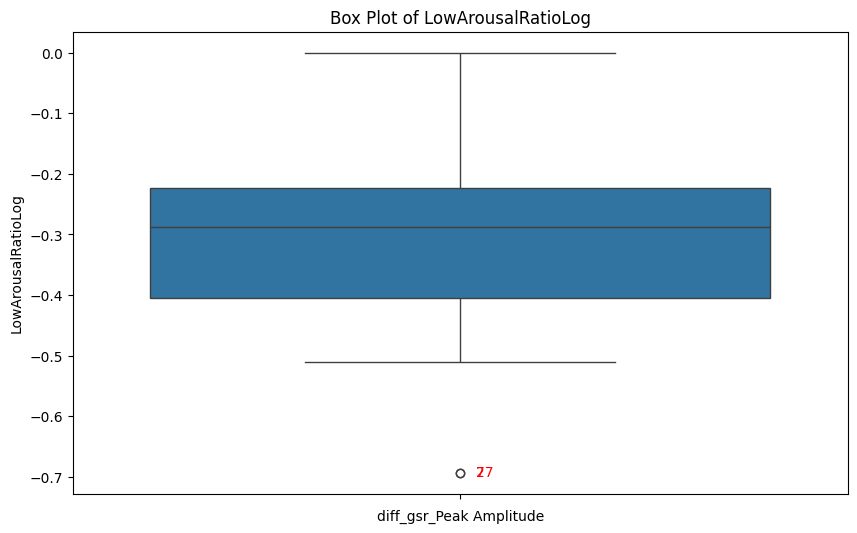

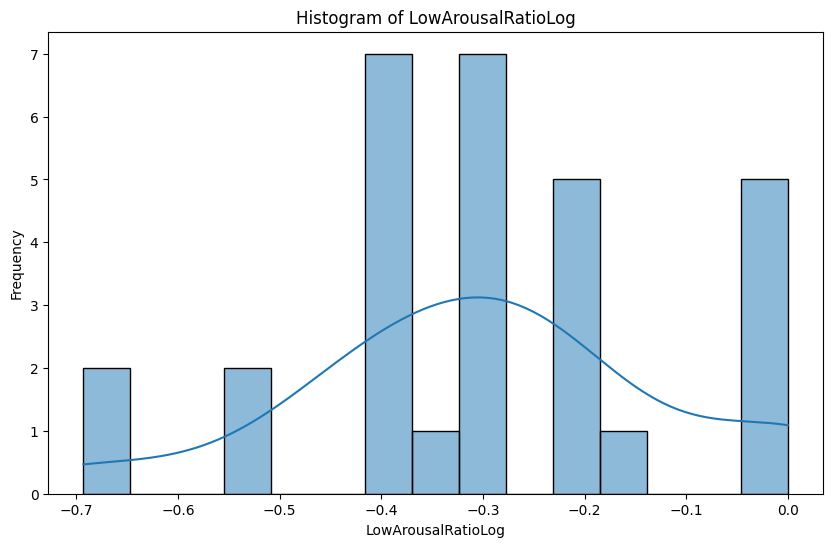

In [100]:
# Check independent variables
x = x2

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[x])
plt.title(f'Box Plot of {x}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[x])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[x], kde=True, bins=15)
plt.xlabel(f'{x}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {x}')
plt.show()

In [101]:
ivs = [x1, x2]  

# Calculate the standard deviation for each independent variable
std_devs = data[ivs].std()

# Check for non-zero variance and print results
print("Standard Deviations of Independent Variables:")
print(std_devs)

# Identify any variables with zero or near-zero variance
near_zero_variance = std_devs[std_devs < 1e-4]  # threshold can be adjusted
if not near_zero_variance.empty:
    print("\nVariables with near-zero variance:")
    print(near_zero_variance)
else:
    print("\nNo variables with near-zero variance detected.")

Standard Deviations of Independent Variables:
InterludeDuration     325.835701
LowArousalRatioLog      0.183010
dtype: float64

No variables with near-zero variance detected.


##### Residuals analysis

In [102]:
# Select predictors 
X = data[[x1, x2]]

# Define model with interaction term (in case it is needed)
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction[x1] * X_w_interaction[x2]

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models
model_no_interaction = sm.OLS(data[response_var], X).fit()
model_w_interaction = sm.OLS(data[response_var], X_w_interaction).fit()


In [103]:
model = model_no_interaction

###### Outliers

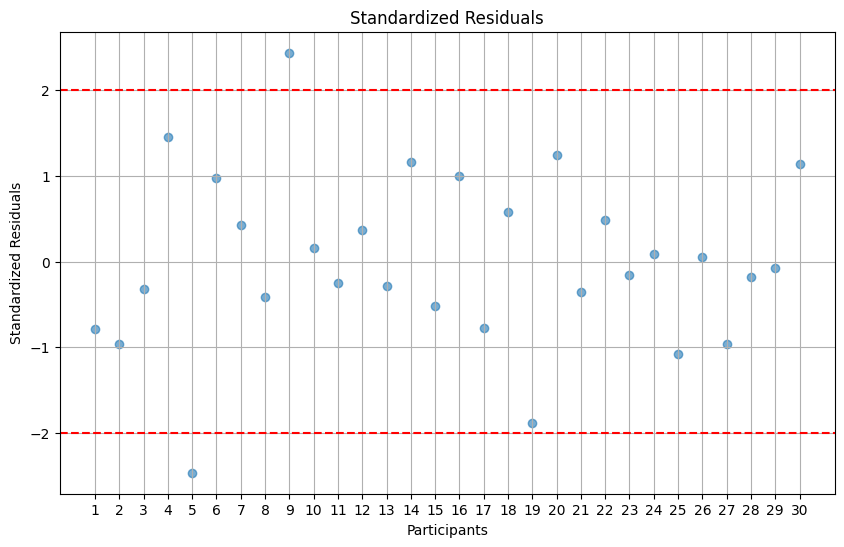

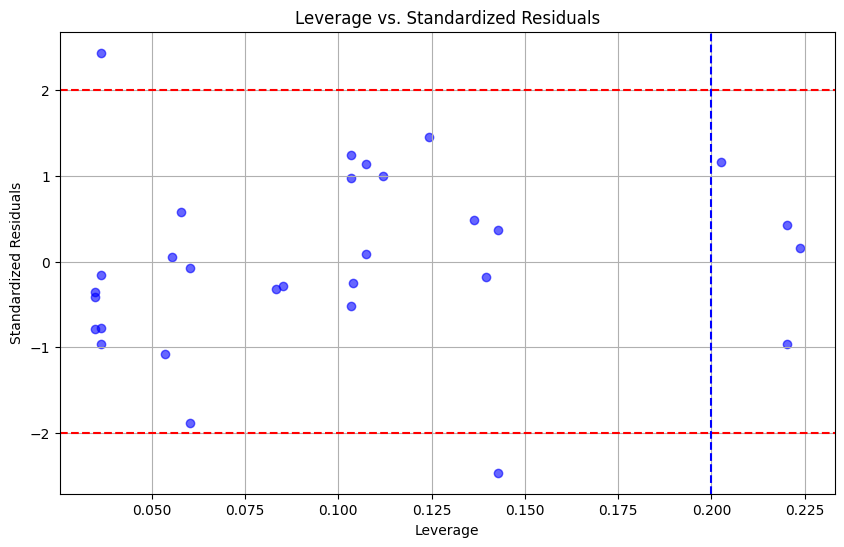

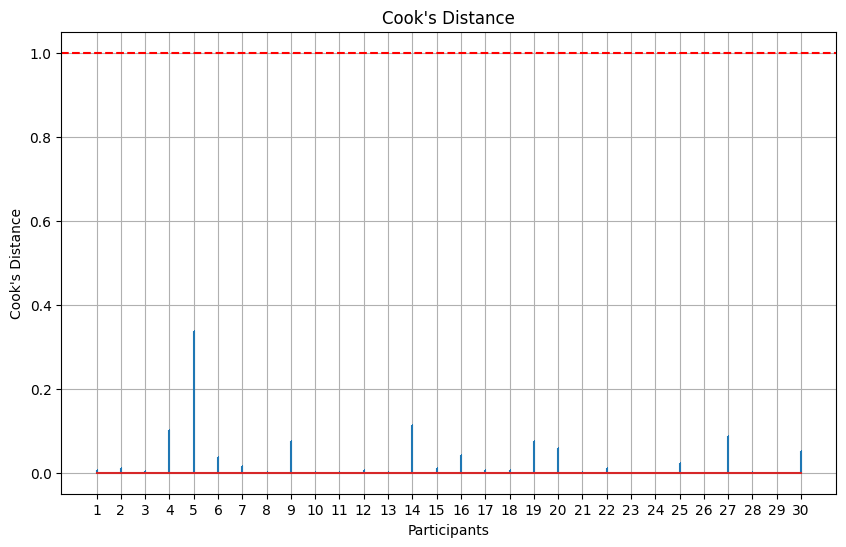

Influential points based on Cook's distance: []


In [104]:
# Standardized Residuals
model.resid_standardized = model.get_influence().resid_studentized_internal

# Leverage
leverage = model.get_influence().hat_matrix_diag

# Cook's Distance
cooks_d = model.get_influence().cooks_distance[0]

# Plot 1
# Plot Standardized Residuals
plt.figure(figsize=(10, 6))
plt.scatter(data.index, model.resid_standardized, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals')
plt.grid(True)
plt.show()

# Plot 2
# Identify outliers (to viually mark)
outlier_mask = abs(model.resid_standardized) > 2.5 # between the 2 and 3 conventions
outlier_indices = data.index[outlier_mask] 

# Plot Leverage vs. Standardized Residuals
plt.figure(figsize=(10, 6))
# Mark outliers using red
plt.scatter(leverage, model.resid_standardized, alpha=0.6, color='blue')  
plt.scatter(leverage[outlier_mask], model.resid_standardized[outlier_mask], alpha=0.6, color='red')  
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axvline(2 * (len(model.params)) / len(model.resid), color='blue', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs. Standardized Residuals')

# Annotate outlier with particiant index 
for index, lev, res in zip(outlier_indices, leverage[outlier_mask], model.resid_standardized[outlier_mask]):
    plt.text(lev+0.008, res, str(index), fontsize=9, ha='right')

plt.grid(True)
plt.show()

# Plot 3
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(data.index, cooks_d, markerfmt=",")
plt.axhline(1, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.grid(True)
plt.show()

# Identify points with high Cook's distance
influential_points = np.where(cooks_d > 1)[0]
print(f"Influential points based on Cook's distance: {influential_points}")



###### Normality

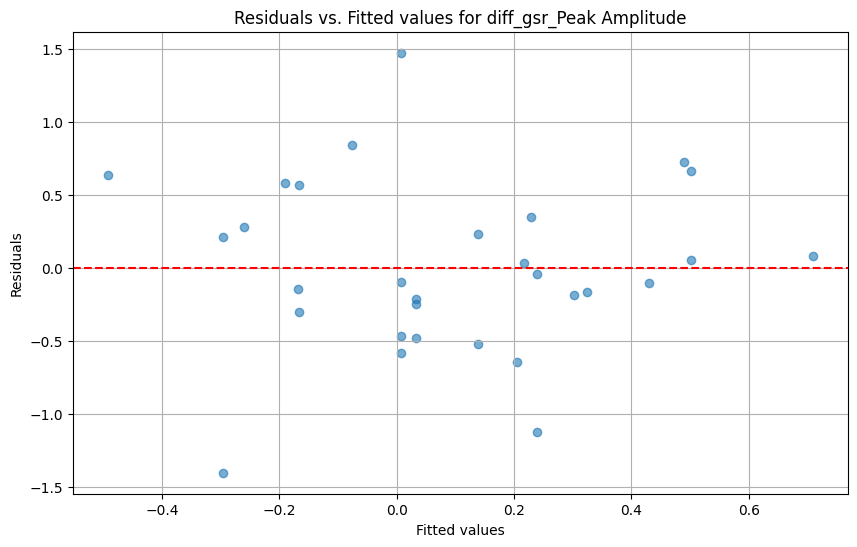

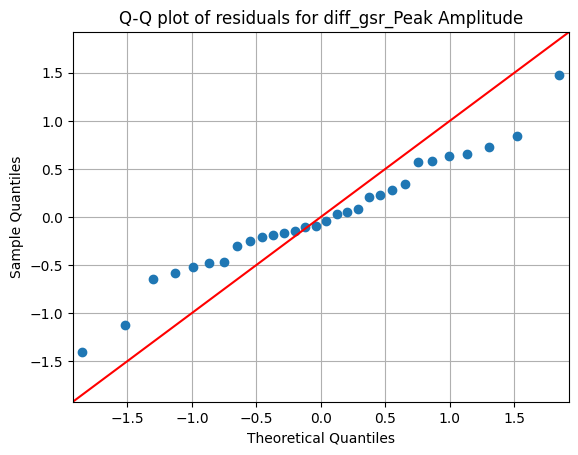

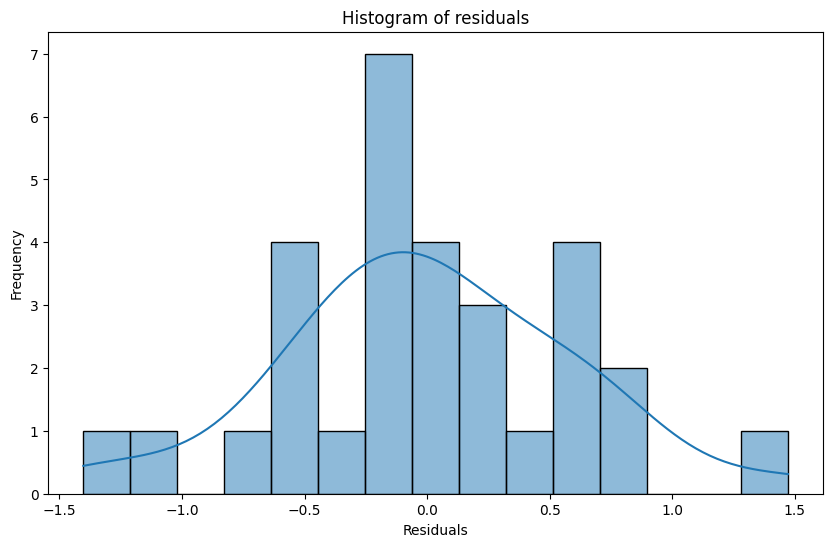

Shapiro-Wilk test: ShapiroResult(statistic=0.9816513061523438, pvalue=0.8675581812858582)
Jarque-Bera test: SignificanceResult(statistic=0.25644079918044177, pvalue=0.8796594811887257)


In [105]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Fitted values for {response_var}')
plt.grid(True)
plt.show()

# Q-Q plot for residuals
sm.qqplot(model.resid, line='45')
plt.title(f'Q-Q plot of residuals for {response_var}')
plt.grid(True)
plt.show()

# Create histogram 
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True, bins=15)
plt.xlabel(f'Residuals')
plt.ylabel('Frequency')
plt.title(f'Histogram of residuals')
plt.show()

# Additional tests

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

###### Independence of residuals

In [106]:
# Durbin-Watson test for independence
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.7964739262002247


###### Homoscedasticity

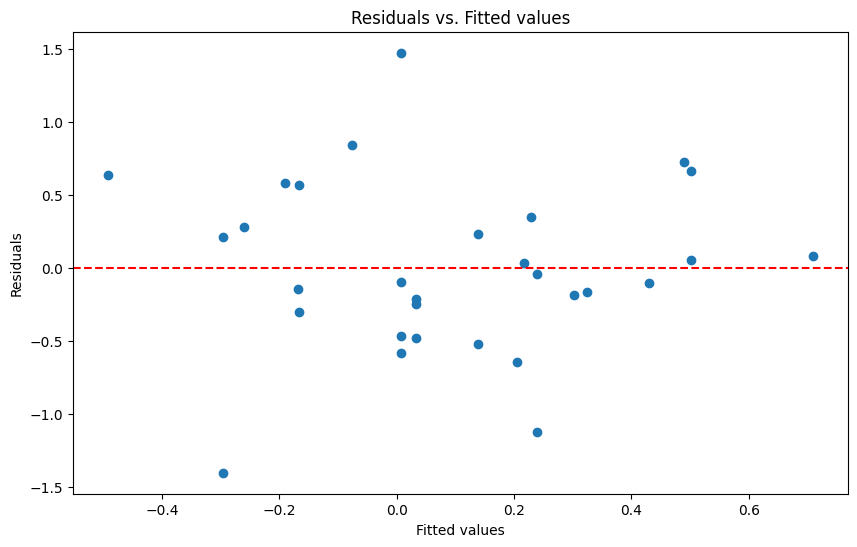

{'LM Statistic': 2.4803821606047185, 'LM-Test p-value': 0.28932892759780454, 'F-Statistic': 1.2167741341316356, 'F-Test p-value': 0.3119144126810632}


In [107]:
# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

###### Multicolinearity

In [108]:
# Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

             Variable        VIF
0               const  11.654906
1   InterludeDuration   1.123608
2  LowArousalRatioLog   1.123608


###### Linearity

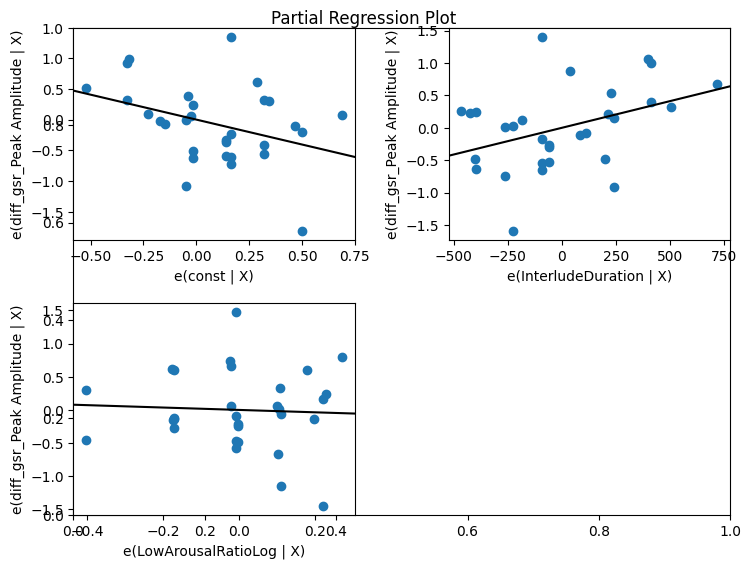

In [109]:
# Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

#### Model fitting and evaluation

In [110]:
# Print model results 
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

Summary for diff_gsr_Peak Amplitude ~ const + InterludeDuration + LowArousalRatioLog:
                               OLS Regression Results                              
Dep. Variable:     diff_gsr_Peak Amplitude   R-squared:                       0.184
Model:                                 OLS   Adj. R-squared:                  0.123
Method:                      Least Squares   F-statistic:                     3.035
Date:                     Tue, 11 Jun 2024   Prob (F-statistic):             0.0647
Time:                             12:23:51   Log-Likelihood:                -26.397
No. Observations:                       30   AIC:                             58.79
Df Residuals:                           27   BIC:                             63.00
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025

In [111]:
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Beta Coefficients:
 const                -0.810511
InterludeDuration     0.000824
LowArousalRatioLog   -0.180282
dtype: float64
Confidence Intervals:
                     Lower CI  Upper CI
const              -1.596851 -0.024171
InterludeDuration   0.000062  0.001587
LowArousalRatioLog -1.537192  1.176629


In [112]:
# # Uncomment for model with interaction term
# formula_w_interaction = derive_formula(model_w_interaction)
# print(f"Summary for {formula_w_interaction}:")
# print(model_w_interaction.summary())

### GSR with-without outlier

#### Original data

In [113]:
# Load data
data = orig_data.copy()
# data.head()

In [114]:
# Set only one predictor
x1 = 'InterludeDuration'

In [115]:
# Select predictors 
X = data[[x1]]

# Add constant 
X = sm.add_constant(X)

# Fit model
model = sm.OLS(data[response_var], X).fit()

In [116]:
# Print model results 
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

print("\n------\n")
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Summary for diff_gsr_Peak Amplitude ~ const + InterludeDuration:
                               OLS Regression Results                              
Dep. Variable:     diff_gsr_Peak Amplitude   R-squared:                       0.181
Model:                                 OLS   Adj. R-squared:                  0.152
Method:                      Least Squares   F-statistic:                     6.200
Date:                     Tue, 11 Jun 2024   Prob (F-statistic):             0.0190
Time:                             12:23:51   Log-Likelihood:                -26.438
No. Observations:                       30   AIC:                             56.88
Df Residuals:                           28   BIC:                             59.68
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------

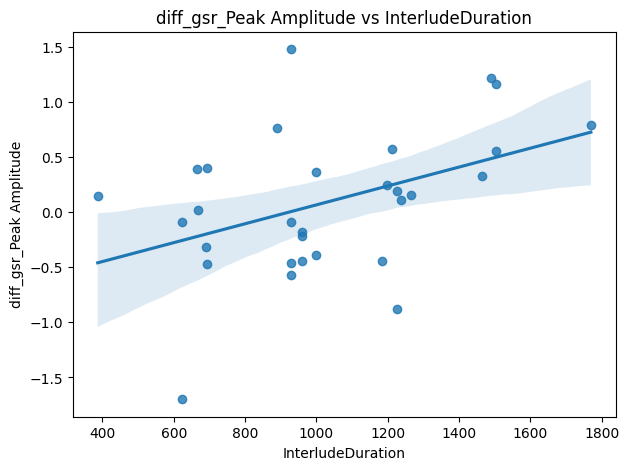

In [117]:
# Plot data with the regression line
plt.figure(figsize=(7, 5))  
sns.regplot(x=x1, y=response_var, data=data)
plt.title(f'{response_var} vs {x1}')
plt.xlabel(x1)
plt.ylabel(response_var)

plt.show()

#### Fit without the outlier

In [118]:
# Load data
data = orig_data.copy()
# data.head()

In [119]:
# Specify outliers to remove
outlier_ids = [5]
for i in outlier_ids:
    data.drop(i, inplace=True)
# data.head()

In [120]:
# Set only one predictor
x1 = 'InterludeDuration'

In [121]:
# Select predictors 
X = data[[x1]]

# Add constant 
X = sm.add_constant(X)

# Fit model
model = sm.OLS(data[response_var], X).fit()

In [122]:
# Print model results
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

print("\n------\n")
# Extract Beta Coefficients
beta_coefficients = model.params
print("Beta Coefficients:\n", beta_coefficients)

# Extract Confidence Intervals
confidence_intervals = model.conf_int()
confidence_intervals.columns = ['Lower CI', 'Upper CI']
print("Confidence Intervals:\n", confidence_intervals)

Summary for diff_gsr_Peak Amplitude ~ const + InterludeDuration:
                               OLS Regression Results                              
Dep. Variable:     diff_gsr_Peak Amplitude   R-squared:                       0.134
Model:                                 OLS   Adj. R-squared:                  0.102
Method:                      Least Squares   F-statistic:                     4.191
Date:                     Tue, 11 Jun 2024   Prob (F-statistic):             0.0505
Time:                             12:23:51   Log-Likelihood:                -22.404
No. Observations:                       29   AIC:                             48.81
Df Residuals:                           27   BIC:                             51.54
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------

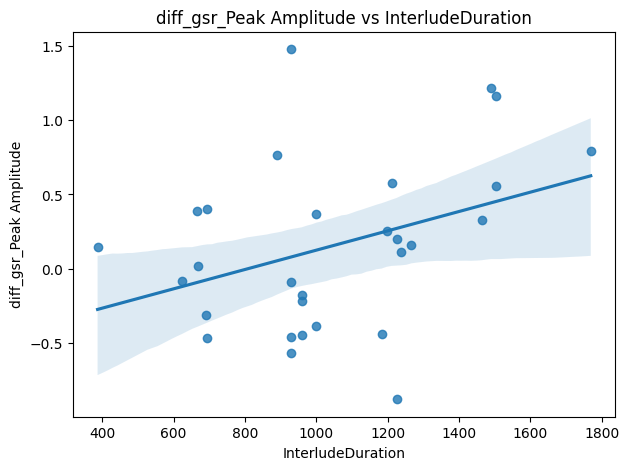

In [123]:
# Plot data with the regression line
plt.figure(figsize=(7, 5))  
sns.regplot(x=x1, y=response_var, data=data)
plt.title(f'{response_var} vs {x1}')
plt.xlabel(x1)
plt.ylabel(response_var)

plt.show()

# Multivariate (Simple) Regression (GSR data)

### Assumptions checking

#### Check assumptions for SCL

In [124]:
# Load data
data = orig_data.copy()
# data.head()
use_transformed = False

In [125]:
# Set dependent variable
response_var = 'diff_gsr_SCL'
# Set predictors
x1 = 'InterludeDuration'

###### Outlier issues: Remove outliers

In [126]:
# data = orig_data.copy()
# # data.head()
# # Specify outliers to remove
# outlier_ids = []
# for i in outlier_ids:
#     data.drop(i, inplace=True)
# # data.head()

###### Outlier issues: Transform data

In [127]:
# # Uncomment to apply yeojohnson transformation to inspect
# data_pre_transform = list(data[response_var])

# # Apply Yeo-Johnson transformation
# data_transformed, lambda_param = yeojohnson(data_pre_transform)
# data_transformed = pd.Series(data_transformed, name='transformed')
# result = pd.DataFrame({'Original Data': data_pre_transform, 'transformed': data_transformed})
# print("Lambda parameter used:", lambda_param)

# # Add the column to data
# result.index = data.index
# data['diff_gsr_SCL_trans'] = result['transformed']

# use_transformed = True


In [128]:
response_var = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'

##### Initial visualization

###### Dependent variables inspection

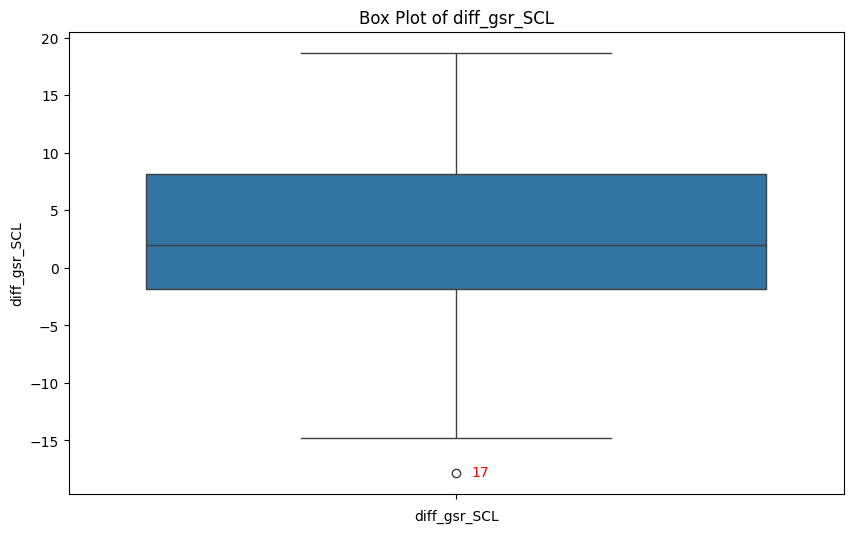

In [129]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[response_var])
plt.title(f'Box Plot of {response_var}')
plt.xlabel(f"{response_var}")

# Get outliers 
outliers = detect_outliers(data[response_var])

# Annotate outliers
for i in outliers.index:
    plt.text(x=0.02, y=outliers.loc[i], s=str(i), color='red', va='center')

plt.show()

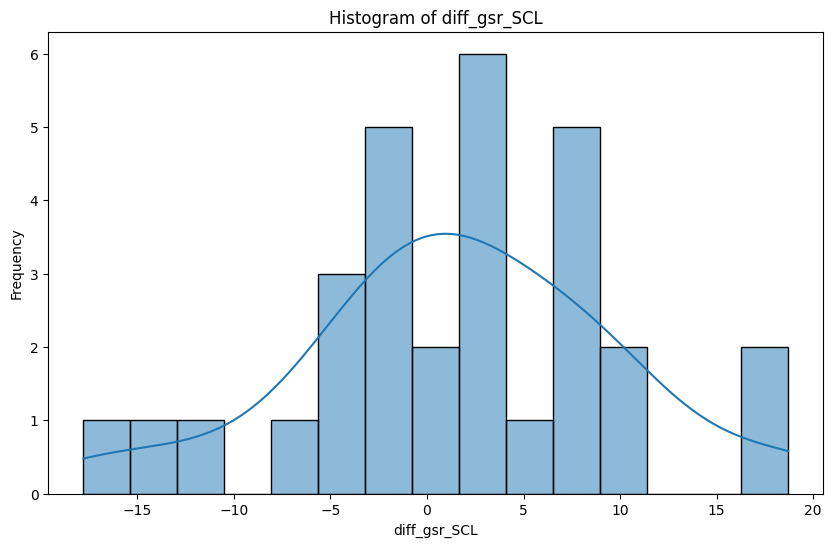

In [130]:
# Create the histogram for the frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(data[response_var], kde=True, bins=15)
plt.xlabel(f'{response_var}')
plt.ylabel('Frequency')
plt.title(f'Histogram of {response_var}')
plt.show()

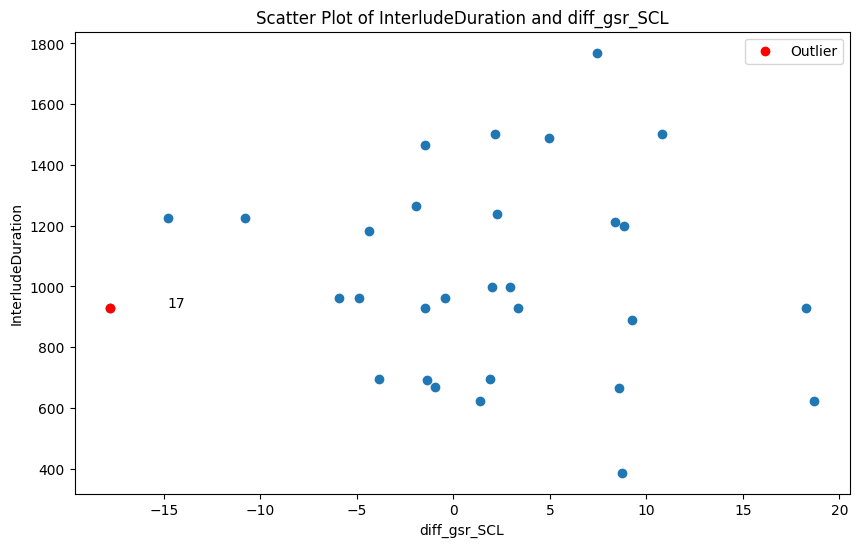

In [131]:
iv = x1
dv = response_var

# Detect outliers in the DV
outliers = detect_outliers(data[dv])

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[dv], data[iv])

# Mark outliers 
plt.scatter(outliers, data.loc[outliers.index, iv], color='red', label='Outlier')

# Annotate outliers with their index (participant number)
for idx in outliers.index:
    plt.text(data.loc[idx, dv] + 3, data.loc[idx, iv], str(idx), color='black')

plt.xlabel(f'{dv}')
plt.ylabel(f'{iv}')
plt.title(f'Scatter Plot of {iv} and {dv}')
plt.legend()
plt.show()

##### Residuals analysis

In [132]:
# Select predictors 
X = data[[x1]]

# Add constant 
X = sm.add_constant(X)

# Fit model
model = sm.OLS(data[response_var], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.1431
Date:                Tue, 11 Jun 2024   Prob (F-statistic):              0.708
Time:                        12:23:52   Log-Likelihood:                -105.31
No. Observations:                  30   AIC:                             214.6
Df Residuals:                      28   BIC:                             217.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.5159      5.13

###### Outliers

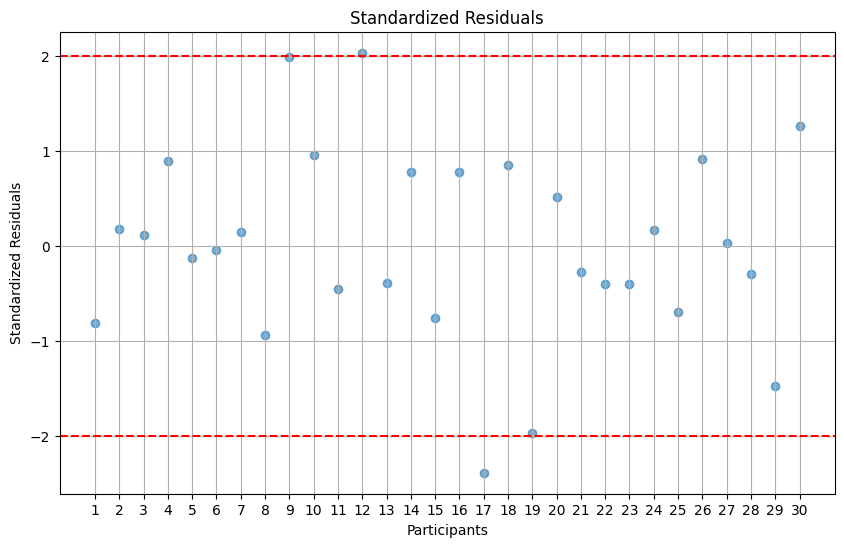

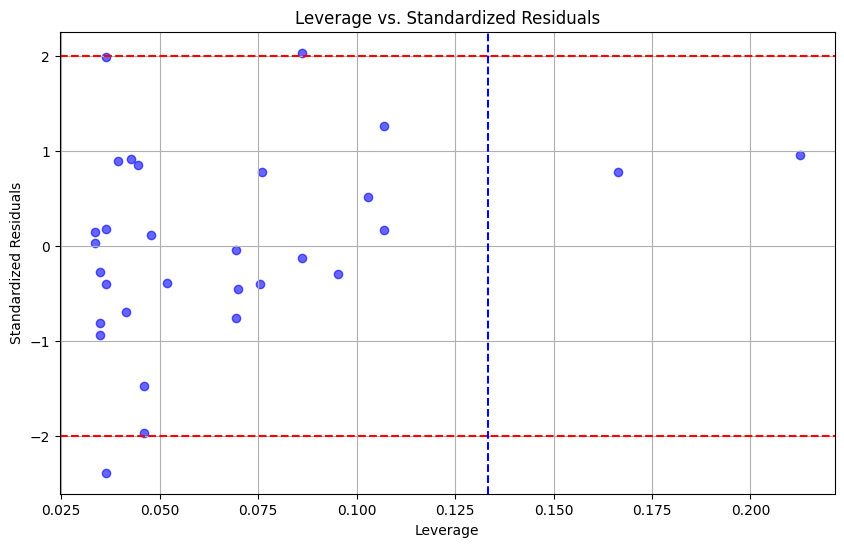

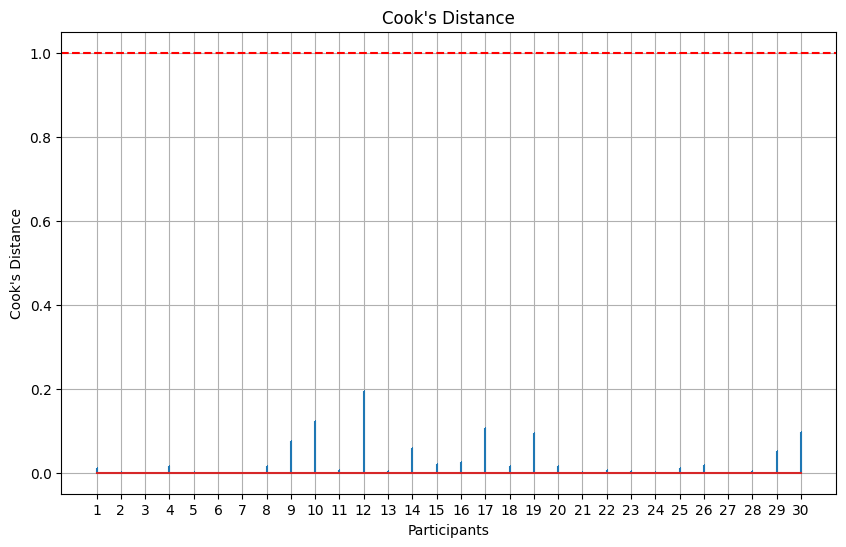

Influential points based on Cook's distance: []


In [133]:
# Standardized Residuals
model.resid_standardized = model.get_influence().resid_studentized_internal

# Leverage
leverage = model.get_influence().hat_matrix_diag

# Cook's Distance
cooks_d = model.get_influence().cooks_distance[0]

# Plot 1
# Plot Standardized Residuals
plt.figure(figsize=(10, 6))
plt.scatter(data.index, model.resid_standardized, alpha=0.6)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals')
plt.grid(True)
plt.show()

# Plot 2
# Identify outliers (to viually mark)
outlier_mask = abs(model.resid_standardized) > 2.5 # between the 2 and 3 conventions
outlier_indices = data.index[outlier_mask] 

# Plot Leverage vs. Standardized Residuals
plt.figure(figsize=(10, 6))
# Mark outliers using red
plt.scatter(leverage, model.resid_standardized, alpha=0.6, color='blue')  
plt.scatter(leverage[outlier_mask], model.resid_standardized[outlier_mask], alpha=0.6, color='red')  
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axvline(2 * (len(model.params)) / len(model.resid), color='blue', linestyle='--')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Leverage vs. Standardized Residuals')

# Annotate outlier with particiant index 
for index, lev, res in zip(outlier_indices, leverage[outlier_mask], model.resid_standardized[outlier_mask]):
    plt.text(lev+0.008, res, str(index), fontsize=9, ha='right')

plt.grid(True)
plt.show()

# Plot 3
# Plot Cook's Distance
plt.figure(figsize=(10, 6))
plt.stem(data.index, cooks_d, markerfmt=",")
plt.axhline(1, color='red', linestyle='--')
plt.xticks(ticks=data.index, labels=data.index)
plt.xlabel('Participants')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.grid(True)
plt.show()

# Identify points with high Cook's distance
influential_points = np.where(cooks_d > 1)[0]
print(f"Influential points based on Cook's distance: {influential_points}")



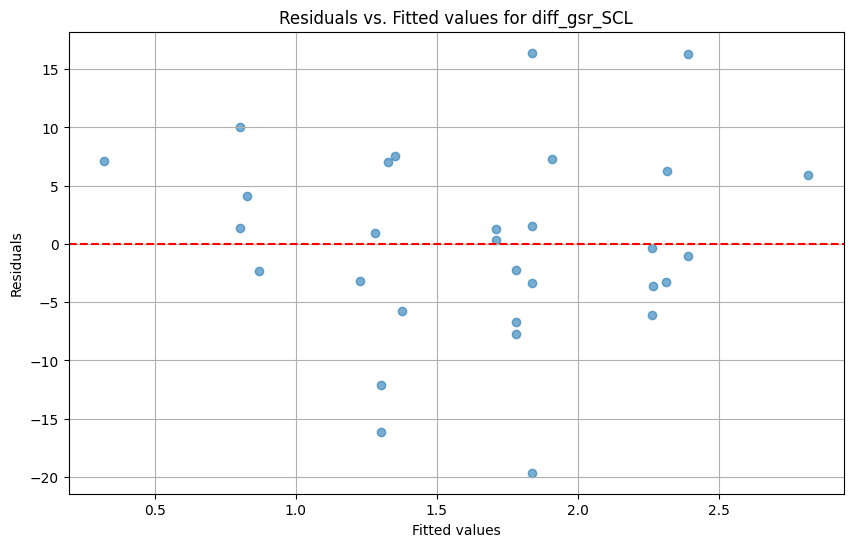

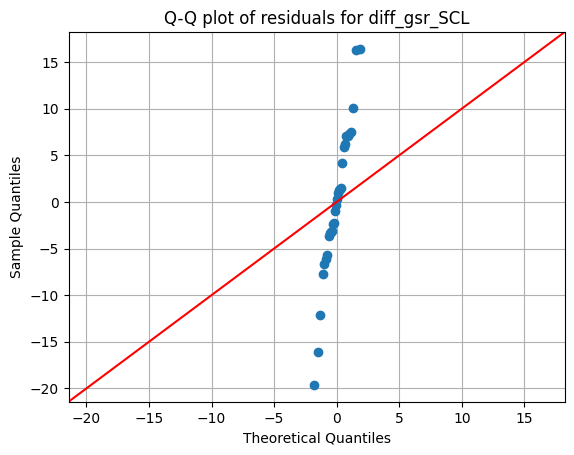

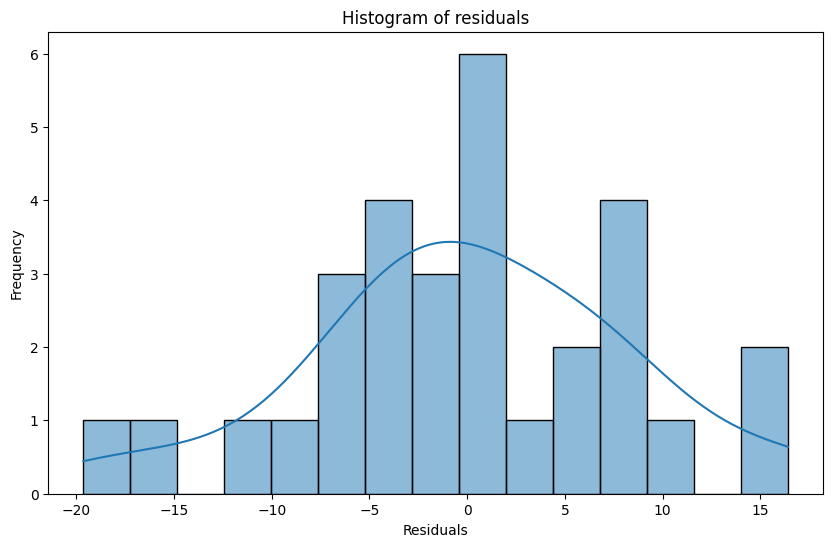

Shapiro-Wilk test: ShapiroResult(statistic=0.9744812250137329, pvalue=0.6674474477767944)
Kolmogorov-Smirnov test: KstestResult(statistic=0.42035163241179113, pvalue=2.5487392283497622e-05, statistic_location=-2.2267587467181276, statistic_sign=1)
Jarque-Bera test: SignificanceResult(statistic=0.23648794126215, pvalue=0.8884792633240124)


In [134]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title(f'Residuals vs. Fitted values for {response_var}')
plt.grid(True)
plt.show()

# Q-Q plot for residuals
sm.qqplot(model.resid, line='45')
plt.title(f'Q-Q plot of residuals for {response_var}')
plt.grid(True)
plt.show()

# Create histogram 
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True, bins=15)
plt.xlabel(f'Residuals')
plt.ylabel('Frequency')
plt.title(f'Histogram of residuals')
plt.show()

# Additional tests

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Extra test for normality
# Kolmogorov-Smirnov test
ks_test = kstest(model.resid, 'norm')
print(f'Kolmogorov-Smirnov test: {ks_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

###### Independence of residuals

In [135]:
# Durbin-Watson test for independence
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.7775349246892076


###### Homoscedasticity

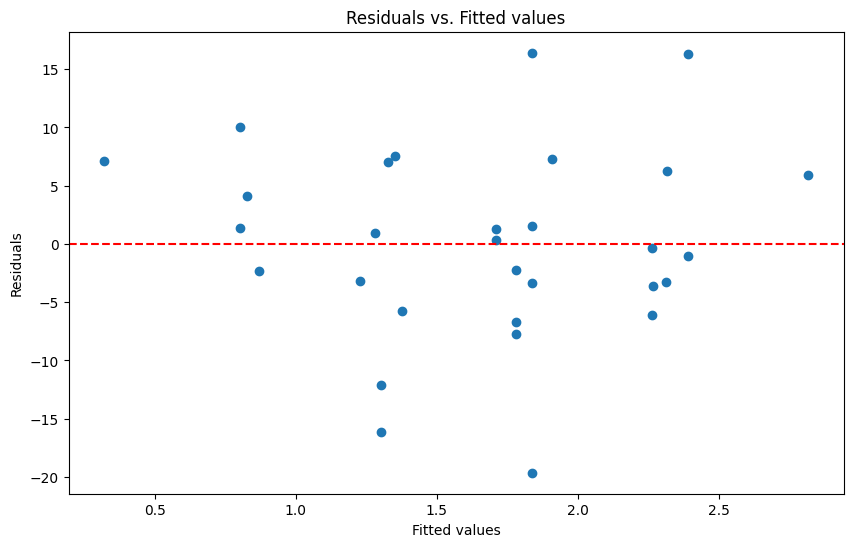

{'LM Statistic': 0.05804242342332788, 'LM-Test p-value': 0.8096171578253015, 'F-Statistic': 0.054277942639414226, 'F-Test p-value': 0.8174745515655396}


In [136]:
# Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

#### Check Multivariate assumptions

In [137]:
# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"


In [138]:
# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]


###### Linearity

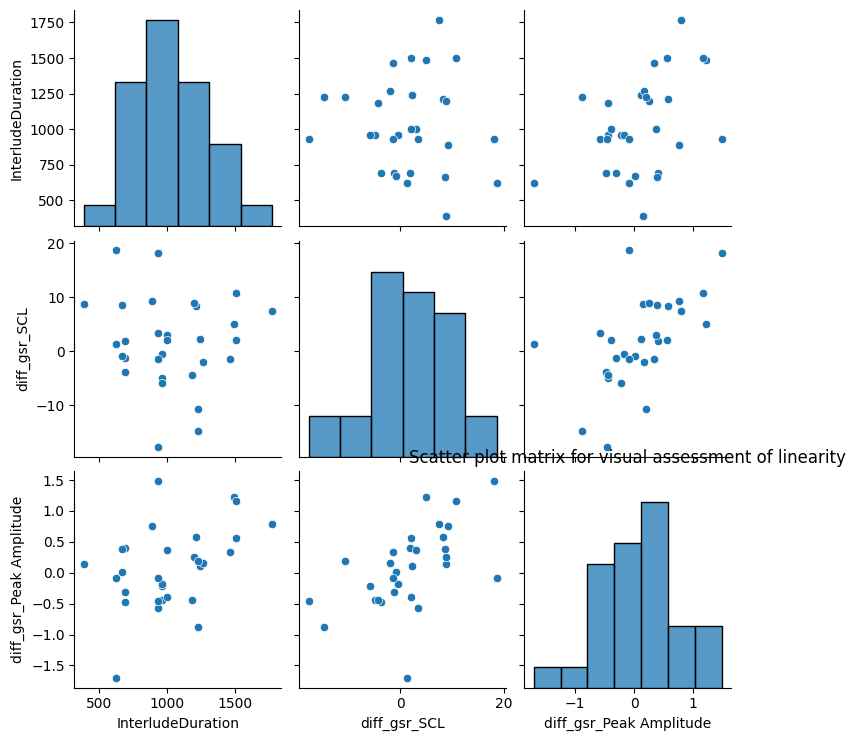

In [139]:
# Scatter plot matrix
sns.pairplot(mvar_data)
plt.title('Scatter plot matrix for visual assessment of linearity')
plt.show()

##### Residual analysis

In [140]:
# Fit linear models
X = sm.add_constant(data[x1])  
model1 = sm.OLS(data[y_1], X).fit()
model2 = sm.OLS(data[y_2], X).fit()

# Collect residuals
residuals = pd.DataFrame({
    f'{y_1}': model1.resid,
    f'{y_2}': model2.resid
})

###### Normality

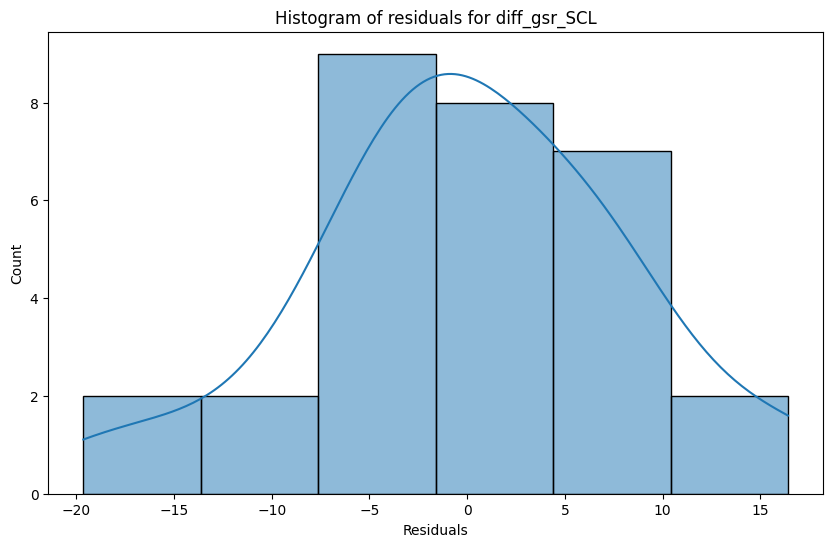

Shapiro-Wilk test for diff_gsr_SCL: ShapiroResult(statistic=0.9699722528457642, pvalue=0.5384165644645691)


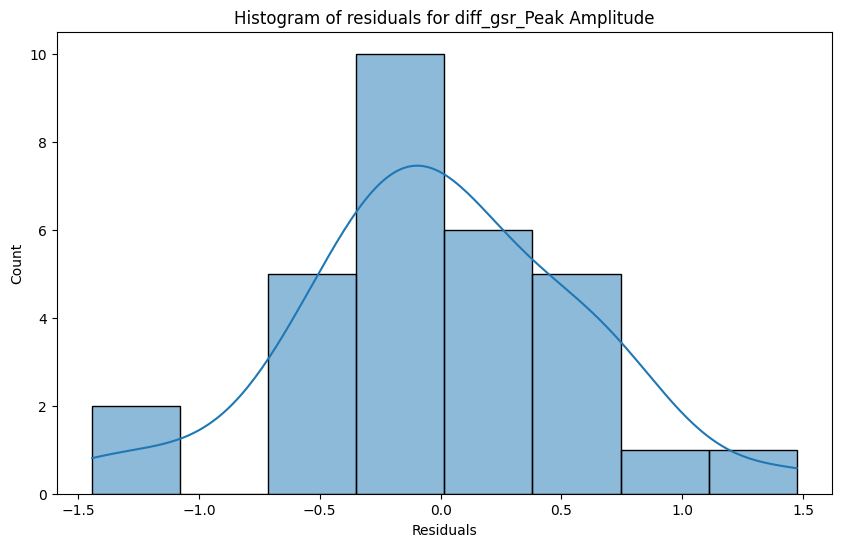

Shapiro-Wilk test for diff_gsr_Peak Amplitude: ShapiroResult(statistic=0.9754936695098877, pvalue=0.6972766518592834)

Multivariate normality:
HZResults(hz=0.5364654519649539, pval=0.2711715255136246, normal=True)


In [141]:
# Plot residuals for normality
for var, resid in residuals.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(resid, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Histogram of residuals for {var}')
    plt.show()

    # Get Shapiro-Wilk test for each dependent 
    shapiro_test = shapiro(mvar_data[var])
    print(f'Shapiro-Wilk test for {var}: {shapiro_test}')

# Perform Henze-Zirkler multivariate normality test
data_to_test = data[[y_1, y_2]]

mult_norm_result = pg.multivariate_normality(data_to_test, alpha=0.05)
print("\nMultivariate normality:")
print(mult_norm_result)


###### Multivariate outliers

In [142]:
# Find multivariate outliers using Mahalanobis distance
mean_vector = residuals.mean(axis=0)
cov_matrix = np.cov(residuals.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

residuals_w_distance = residuals.copy()
# Apply Mahalanobis distance calculation for each row
residuals_w_distance['mahalanobis_distance'] = residuals.apply(
    lambda row: mahalanobis(row, mean_vector, inv_cov_matrix), axis=1
)

# Critical value for alpha = 0.01 (convention)
critical_value = chi2.ppf(0.99, df=len(residuals.columns))  
assert len(residuals.columns) == 2

# Identify outliers

residuals_w_distance['outlier'] = residuals_w_distance['mahalanobis_distance'] > critical_value
outliers = residuals_w_distance[residuals_w_distance['outlier']]
print(outliers if len(outliers) > 0 else 'No multivariate outliers.')


No multivariate outliers.


###### Homoscedasticity

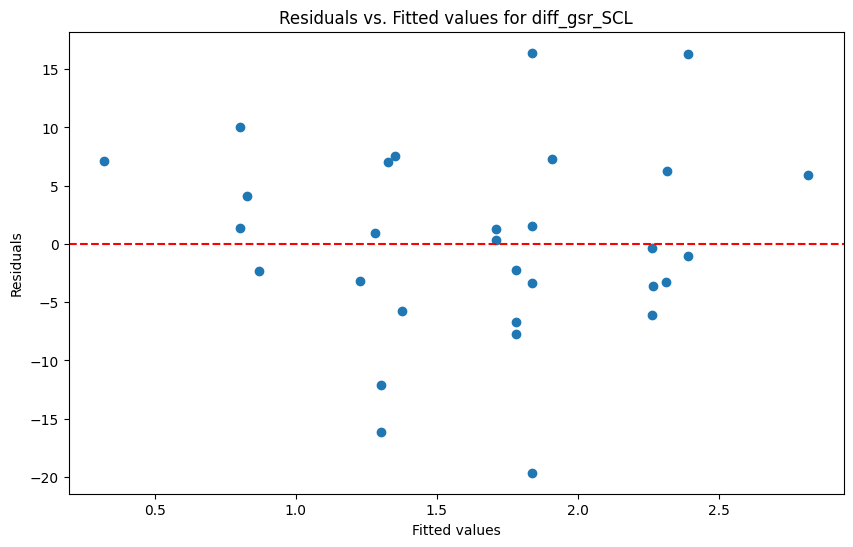

Breusch-Pagan test for diff_gsr_SCL: {'LM Statistic': 0.05804242342332788, 'LM-Test p-value': 0.8096171578253015, 'F-Statistic': 0.054277942639414226, 'F-Test p-value': 0.8174745515655396}


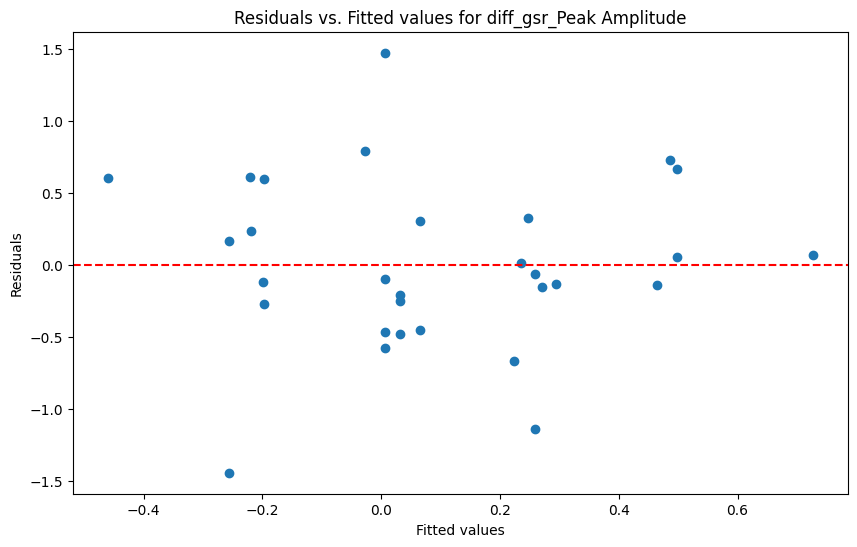

Breusch-Pagan test for diff_gsr_Peak Amplitude: {'LM Statistic': 0.9652840456233958, 'LM-Test p-value': 0.3258591472199236, 'F-Statistic': 0.9308840258649379, 'F-Test p-value': 0.34289297296253174}


In [143]:
# Plot and Breusch-Pagan test

# Fit OLS models for each dependent variable to get residuals
X = mvar_data[[x1]]
X = sm.add_constant(X)  

residuals = {}
for var in dependent_vars:
    model = sm.OLS(mvar_data[var], X).fit()
    residuals[var] = model.resid

    # Plot residuals vs. fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for {var}')
    plt.show()

    # Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(f'Breusch-Pagan test for {var}: {dict(zip(labels, bp_test))}')



### Model fitting and evaluation

#### Original data

In [144]:
data = orig_data.copy()
use_transformed = False

In [145]:
# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"

# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]


In [146]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(formula)
print(mvar_model_results)

Q("diff_gsr_SCL") + Q("diff_gsr_Peak Amplitude") ~ Q("InterludeDuration")
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6954 2.0000 27.0000  5.9136 0.0074
         Pillai's trace 0.3046 2.0000 27.0000  5.9136 0.0074
 Hotelling-Lawley trace 0.4380 2.0000 27.0000  5.9136 0.0074
    Roy's greatest root 0.4380 2.0000 27.0000  5.9136 0.0074
------------------------------------------------------------
                                                            
------------------------------------------------------------
 Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6768 2.0000 27.0000  6.4478 0.0051
         Pillai's trace 0.323

#### Handle outlier (only if not CPA)

Note: Run the following only on the data without CPA segmentation, as then there is no outlier

##### Original data (+no univariate outlier)

In [147]:
data = orig_data.copy()
use_transformed = False

In [148]:
# Specify outliers to remove
outlier_ids = [17]
for i in outlier_ids:
    data.drop(i, inplace=True)
# data.head()

In [149]:
# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"

# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]


In [150]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6515 2.0000 26.0000  6.9541 0.0038
         Pillai's trace 0.3485 2.0000 26.0000  6.9541 0.0038
 Hotelling-Lawley trace 0.5349 2.0000 26.0000  6.9541 0.0038
    Roy's greatest root 0.5349 2.0000 26.0000  6.9541 0.0038
------------------------------------------------------------
                                                            
------------------------------------------------------------
 Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6498 2.0000 26.0000  7.0067 0.0037
         Pillai's trace 0.3502 2.0000 26.0000  7.0067 0.0037
 Hotelling-Lawley trace 0.5390 2.0000 26.0

##### Transformed data

In [151]:
data = orig_data.copy()
use_transformed = False

In [152]:
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'

In [153]:
# Uncomment to apply yeojohnson transformation to inspect
data_pre_transform = list(data[y_1])

# Apply Yeo-Johnson transformation
data_transformed, lambda_param = yeojohnson(data_pre_transform)
data_transformed = pd.Series(data_transformed, name='transformed')
result = pd.DataFrame({'Original Data': data_pre_transform, 'transformed': data_transformed})
print("Lambda parameter used:", lambda_param)

# Add the column to data
result.index = data.index
data['diff_gsr_SCL_trans'] = result['transformed']

use_transformed = True


Lambda parameter used: 1.027078969510395


In [154]:
# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]

# Predictor
x1 = "InterludeDuration"

# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]


In [155]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6848 2.0000 27.0000  6.2145 0.0060
         Pillai's trace 0.3152 2.0000 27.0000  6.2145 0.0060
 Hotelling-Lawley trace 0.4603 2.0000 27.0000  6.2145 0.0060
    Roy's greatest root 0.4603 2.0000 27.0000  6.2145 0.0060
------------------------------------------------------------
                                                            
------------------------------------------------------------
 Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6728 2.0000 27.0000  6.5661 0.0047
         Pillai's trace 0.3272 2.0000 27.0000  6.5661 0.0047
 Hotelling-Lawley trace 0.4864 2.0000 27.0

##### Transformed data (+no univariate outlier)

In [156]:
data = orig_data.copy()
use_transformed = False

In [157]:
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'

In [158]:
# Uncomment to apply yeojohnson transformation to inspect
data_pre_transform = list(data[y_1])

# Apply Yeo-Johnson transformation
data_transformed, lambda_param = yeojohnson(data_pre_transform)
data_transformed = pd.Series(data_transformed, name='transformed')
trans_df = pd.DataFrame({'Original Data': data_pre_transform, 'transformed': data_transformed})
print("Lambda parameter used:", lambda_param)

# Add the column to data
trans_df.index = data.index
data['diff_gsr_SCL_trans'] = trans_df['transformed']

use_transformed = True


Lambda parameter used: 1.027078969510395


In [159]:
# data.head()
# Specify outliers to remove
outlier_ids = [17]
for i in outlier_ids:
    data.drop(i, inplace=True)
# data.head()

In [160]:
# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]

# Predictor
x1 = "InterludeDuration"

# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]


In [161]:
# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6448 2.0000 26.0000  7.1622 0.0033
         Pillai's trace 0.3552 2.0000 26.0000  7.1622 0.0033
 Hotelling-Lawley trace 0.5509 2.0000 26.0000  7.1622 0.0033
    Roy's greatest root 0.5509 2.0000 26.0000  7.1622 0.0033
------------------------------------------------------------
                                                            
------------------------------------------------------------
 Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6490 2.0000 26.0000  7.0322 0.0036
         Pillai's trace 0.3510 2.0000 26.0000  7.0322 0.0036
 Hotelling-Lawley trace 0.5409 2.0000 26.0

#### Separate linear models

In [162]:
data = orig_data.copy()
use_transformed = False

# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]

# Predictor
x1 = "InterludeDuration"

# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]


In [163]:
# Fit separate OLS models for each dependent variable
formula_1 = f'Q("{y_1}") ~ Q("{x1}")'
formula_2 = f'Q("{y_2}") ~ Q("{x1}")'

model_1 = smf.ols(formula_1, data=data).fit()
model_2 = smf.ols(formula_2, data=data).fit()

# Print the summary of each model
print("Model for SCL")
print(formula_1)
print(model_1.summary())

Model for SCL
Q("diff_gsr_SCL") ~ Q("InterludeDuration")
                            OLS Regression Results                            
Dep. Variable:      Q("diff_gsr_SCL")   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.1431
Date:                Tue, 11 Jun 2024   Prob (F-statistic):              0.708
Time:                        12:23:56   Log-Likelihood:                -105.31
No. Observations:                  30   AIC:                             214.6
Df Residuals:                      28   BIC:                             217.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

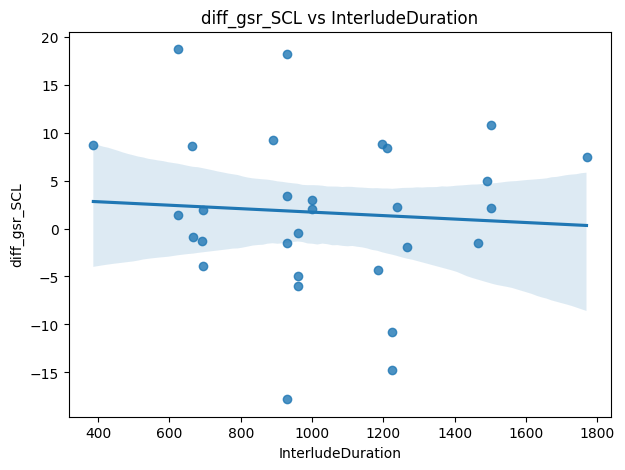

In [164]:
# Plot data with the regression line
plt.figure(figsize=(7, 5))  
sns.regplot(x=x1, y=y_1, data=data)
plt.title(f'{response_var} vs {x1}')
plt.xlabel(x1)
plt.ylabel(response_var)

plt.show()

##### Original 

In [165]:
print("Model for GSR Peak")
print(formula_2)
print(model_2.summary())

Model for GSR Peak
Q("diff_gsr_Peak Amplitude") ~ Q("InterludeDuration")
                                 OLS Regression Results                                 
Dep. Variable:     Q("diff_gsr_Peak Amplitude")   R-squared:                       0.181
Model:                                      OLS   Adj. R-squared:                  0.152
Method:                           Least Squares   F-statistic:                     6.200
Date:                          Tue, 11 Jun 2024   Prob (F-statistic):             0.0190
Time:                                  12:23:56   Log-Likelihood:                -26.438
No. Observations:                            30   AIC:                             56.88
Df Residuals:                                28   BIC:                             59.68
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                             coef    

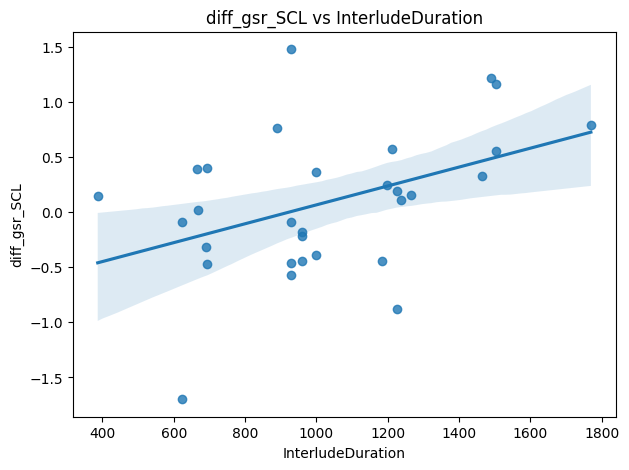

In [166]:
# Plot data with the regression line
plt.figure(figsize=(7, 5))  
sns.regplot(x=x1, y=y_2, data=data)
plt.title(f'{response_var} vs {x1}')
plt.xlabel(x1)
plt.ylabel(response_var)

plt.show()

##### No outlier

In [167]:
# # Specify outliers to remove
# outlier_ids = [5]
# for i in outlier_ids:
#     data.drop(i, inplace=True)
# # data.head()

# model_2 = smf.ols(formula_2, data=data).fit()

# print("Model for GSR Peak (no outlier)")
# print(formula_2)
# print(model_2.summary())

# Post-hoc correlation analysis

In [168]:
data = orig_data.copy()

In [169]:
relevant_columns = ['InterludeDuration', 'LowArousalRatioLog', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL']
# # Extended version (1 more predictor and 1 more GSR feature)
# relevant_columns.extend(['Low Ar. time bfr 2nd', 'diff_gsr_SCR'])
corr_data = data[relevant_columns]

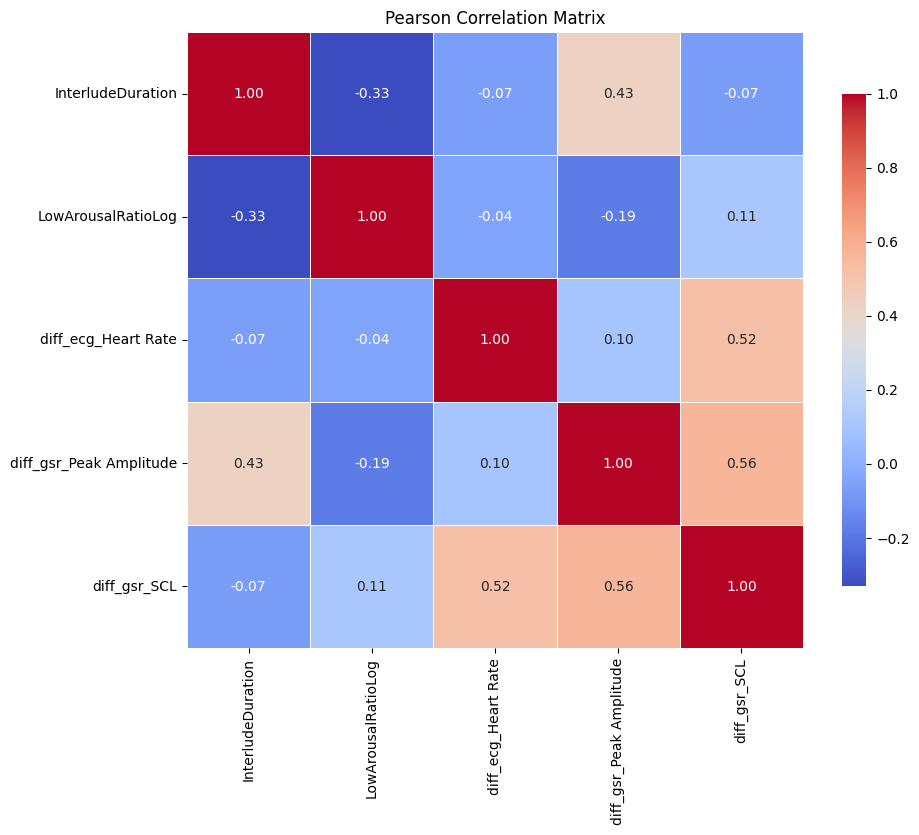

In [170]:
# Calculate the Pearson correlation matrix
correlation_matrix = corr_data.corr(method='pearson')

# Create heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Pearson Correlation Matrix')
plt.show()

# TODO: Power analysis and model comparison

### Power of multiple linear regression 

In [171]:
# Load data
data = orig_data.copy()
# data.head()

Summary for diff_gsr_Peak Amplitude ~ const + InterludeDuration + LowArousalRatioLog:

                               OLS Regression Results                              
Dep. Variable:     diff_gsr_Peak Amplitude   R-squared:                       0.184
Model:                                 OLS   Adj. R-squared:                  0.123
Method:                      Least Squares   F-statistic:                     3.035
Date:                     Tue, 11 Jun 2024   Prob (F-statistic):             0.0647
Time:                             12:23:57   Log-Likelihood:                -26.397
No. Observations:                       30   AIC:                             58.79
Df Residuals:                           27   BIC:                             63.00
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.02

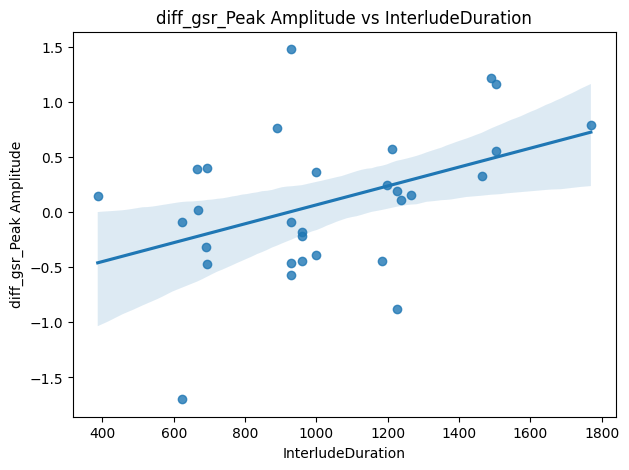

In [172]:
# Set only one predictor
x1 = 'InterludeDuration'
x2 = 'LowArousalRatioLog'

response_var = 'diff_gsr_Peak Amplitude'

# Select predictors 
X = data[[x1, x2]]

# Add constant 
X = sm.add_constant(X)

# Fit model
model = sm.OLS(data[response_var], X).fit()

# Print selected model results 
formula = derive_formula(model)

print(f"Summary for {formula}:\n")
print(model.summary())

# Plot data with the regression line
plt.figure(figsize=(7, 5))  
sns.regplot(x=x1, y=response_var, data=data)
plt.title(f'{response_var} vs {x1}')
plt.xlabel(x1)
plt.ylabel(response_var)

plt.show()

### Power of univariate model

In [173]:
# Load data
data = orig_data.copy()

Summary for diff_gsr_Peak Amplitude ~ const + InterludeDuration:
                               OLS Regression Results                              
Dep. Variable:     diff_gsr_Peak Amplitude   R-squared:                       0.181
Model:                                 OLS   Adj. R-squared:                  0.152
Method:                      Least Squares   F-statistic:                     6.200
Date:                     Tue, 11 Jun 2024   Prob (F-statistic):             0.0190
Time:                             12:23:57   Log-Likelihood:                -26.438
No. Observations:                       30   AIC:                             56.88
Df Residuals:                           28   BIC:                             59.68
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------

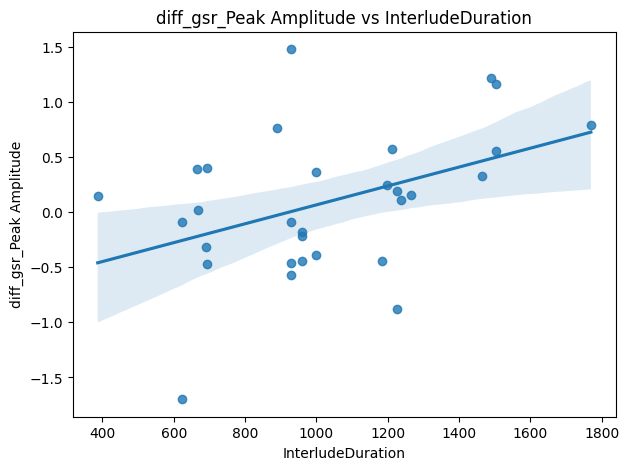

In [174]:
# Set only one predictor
x1 = 'InterludeDuration'
response_var = 'diff_gsr_Peak Amplitude'

# Select predictors 
X = data[[x1]]

# Add constant 
X = sm.add_constant(X)

# Fit model
model = sm.OLS(data[response_var], X).fit()

# Print selected model results 
formula = derive_formula(model)

print(f"Summary for {formula}:")
print(model.summary())

# Plot data with the regression line
plt.figure(figsize=(7, 5))  
sns.regplot(x=x1, y=response_var, data=data)
plt.title(f'{response_var} vs {x1}')
plt.xlabel(x1)
plt.ylabel(response_var)

plt.show()

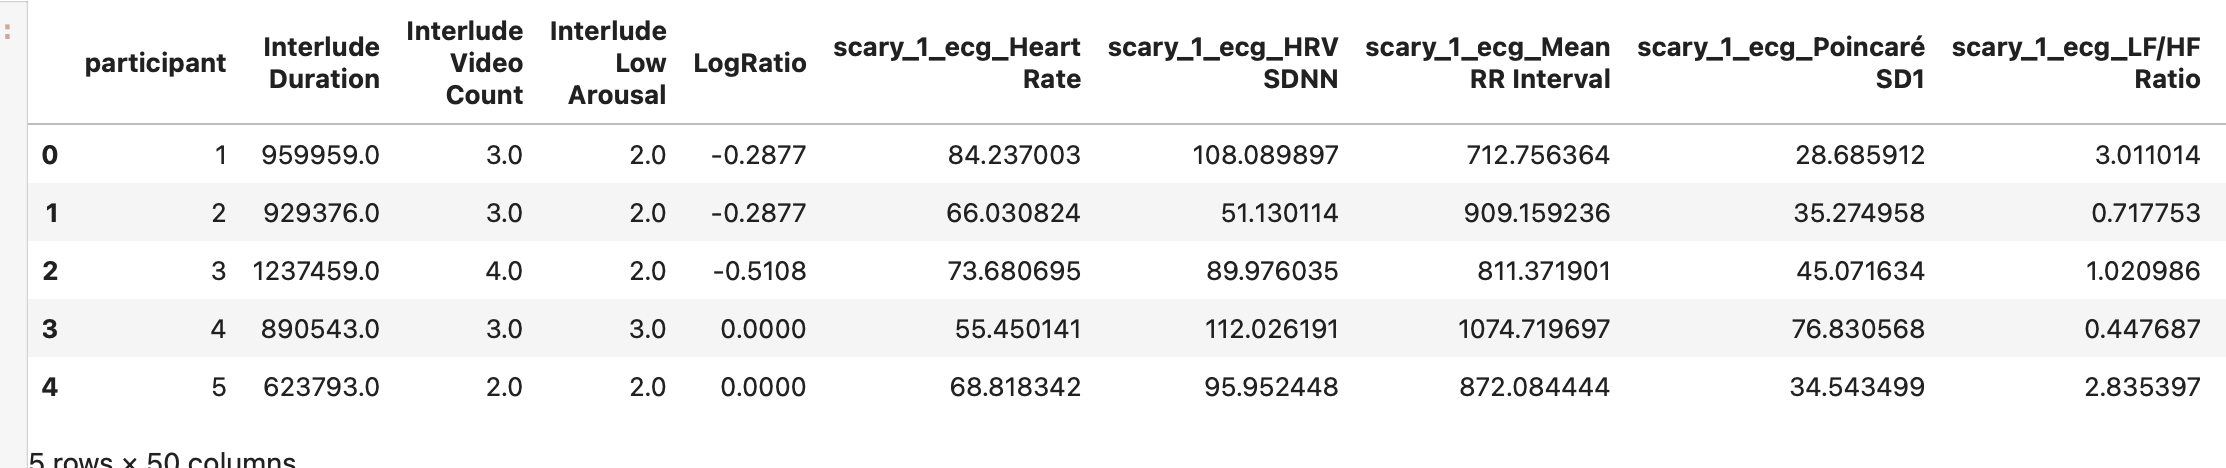

In [175]:
display.Image("Screenshot 2024-05-30 at 15.58.47.png")

### Power of multivariate model (mutliple predictors)

Based on this:
Morse, David. (2020). Re: Can I use G power to calculate the sample size for a multivariate regression model ? . Retrieved from: https://www.researchgate.net/post/Can_I_use_G_power_to_calculate_the_sample_size_for_a_multivariate_regression_model/5fcab1b5c51432254e125042/citation/download. 

In [176]:
# Load data
data = orig_data.copy()

In [177]:
# Dependent variables
y_1 = 'diff_ecg_Heart Rate'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"
x2 = "LowArousalRatioLog"

In [178]:
# Keep relevant columns
relevant_columns = [x1, x2, y_1, y_2]
mvar_data = data[relevant_columns]

# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q(f"{x1}") + Q(f"{x2}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(mvar_model_results)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8529 2.0000 26.0000  2.2428 0.1263
           Pillai's trace 0.1471 2.0000 26.0000  2.2428 0.1263
   Hotelling-Lawley trace 0.1725 2.0000 26.0000  2.2428 0.1263
      Roy's greatest root 0.1725 2.0000 26.0000  2.2428 0.1263
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
  Q(f"InterludeDuration") Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8311 2.0000 26.0000  2.6428 0.0902
           Pillai's trace 0.1689 2.0000 26.0000  2.6428 0.0902
   Hotellin

### Power of multivariate model

In [179]:
# Load data
ata = orig_data.copy()
use_transformed = False

In [180]:
# Dependent variables
y_1 = 'diff_gsr_SCL_trans' if use_transformed else 'diff_gsr_SCL'
y_2 = 'diff_gsr_Peak Amplitude'
dependent_vars = [y_1, y_2]
# Predictor
x1 = "InterludeDuration"

Q("diff_gsr_SCL") + Q("diff_gsr_Peak Amplitude") ~ Q("InterludeDuration")
                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6954 2.0000 27.0000  5.9136 0.0074
         Pillai's trace 0.3046 2.0000 27.0000  5.9136 0.0074
 Hotelling-Lawley trace 0.4380 2.0000 27.0000  5.9136 0.0074
    Roy's greatest root 0.4380 2.0000 27.0000  5.9136 0.0074
------------------------------------------------------------
                                                            
------------------------------------------------------------
 Q("InterludeDuration") Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6768 2.0000 27.0000  6.4478 0.0051
         Pillai's trace 0.323

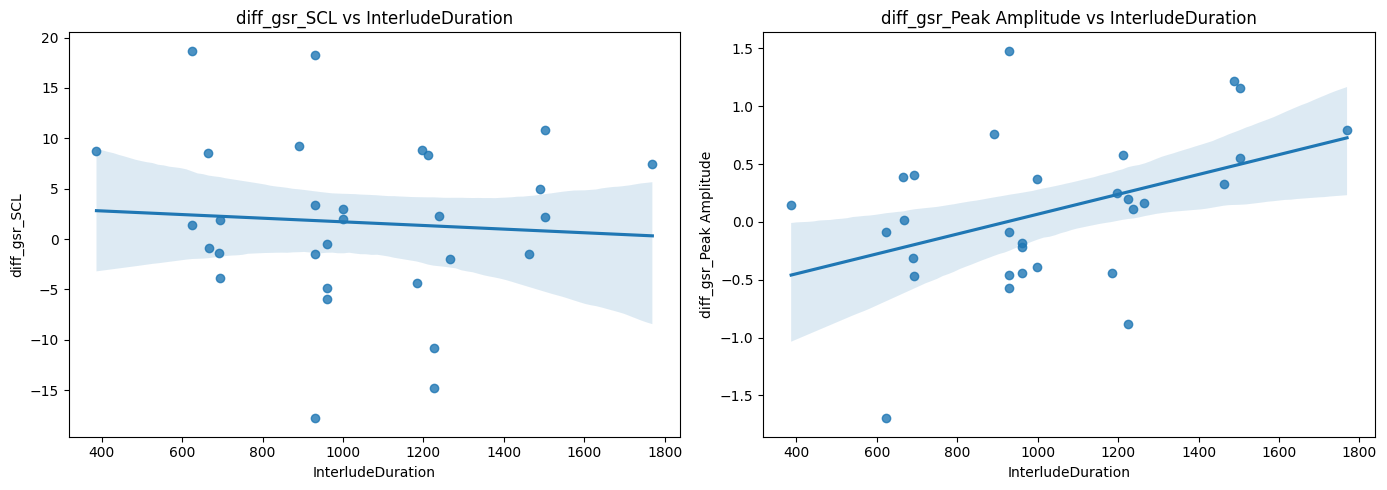

In [181]:
# Keep relevant columns
relevant_columns = [x1, y_1, y_2]
mvar_data = data[relevant_columns]

# Define the formula 
formula = f'Q("{y_1}") + Q("{y_2}") ~ Q("{x1}")'

# Fit the multivariate model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()
print(formula)
print(mvar_model_results)

# Create combined plot
plt.figure(figsize=(14, 5))  

# Mean SCL
plt.subplot(1, 2, 1)  
sns.regplot(x=x1, y=y_1, data=data)
plt.title(f'{y_1} vs {x1}')
plt.xlabel(x1)
plt.ylabel(y_1)

# GSR Peak Amplitude
plt.subplot(1, 2, 2) 
sns.regplot(x=x1, y=y_2, data=data)
plt.title(f'{y_2} vs {x1}')
plt.xlabel(x1)
plt.ylabel(y_2)

plt.tight_layout() 
plt.show()

In [182]:
# example

In [183]:
R_squared = model.rsquared
print(model.rsquared)
f_squared = R_squared / (1 - R_squared)
print(f_squared)


0.18129671667509006
0.22144373959123453


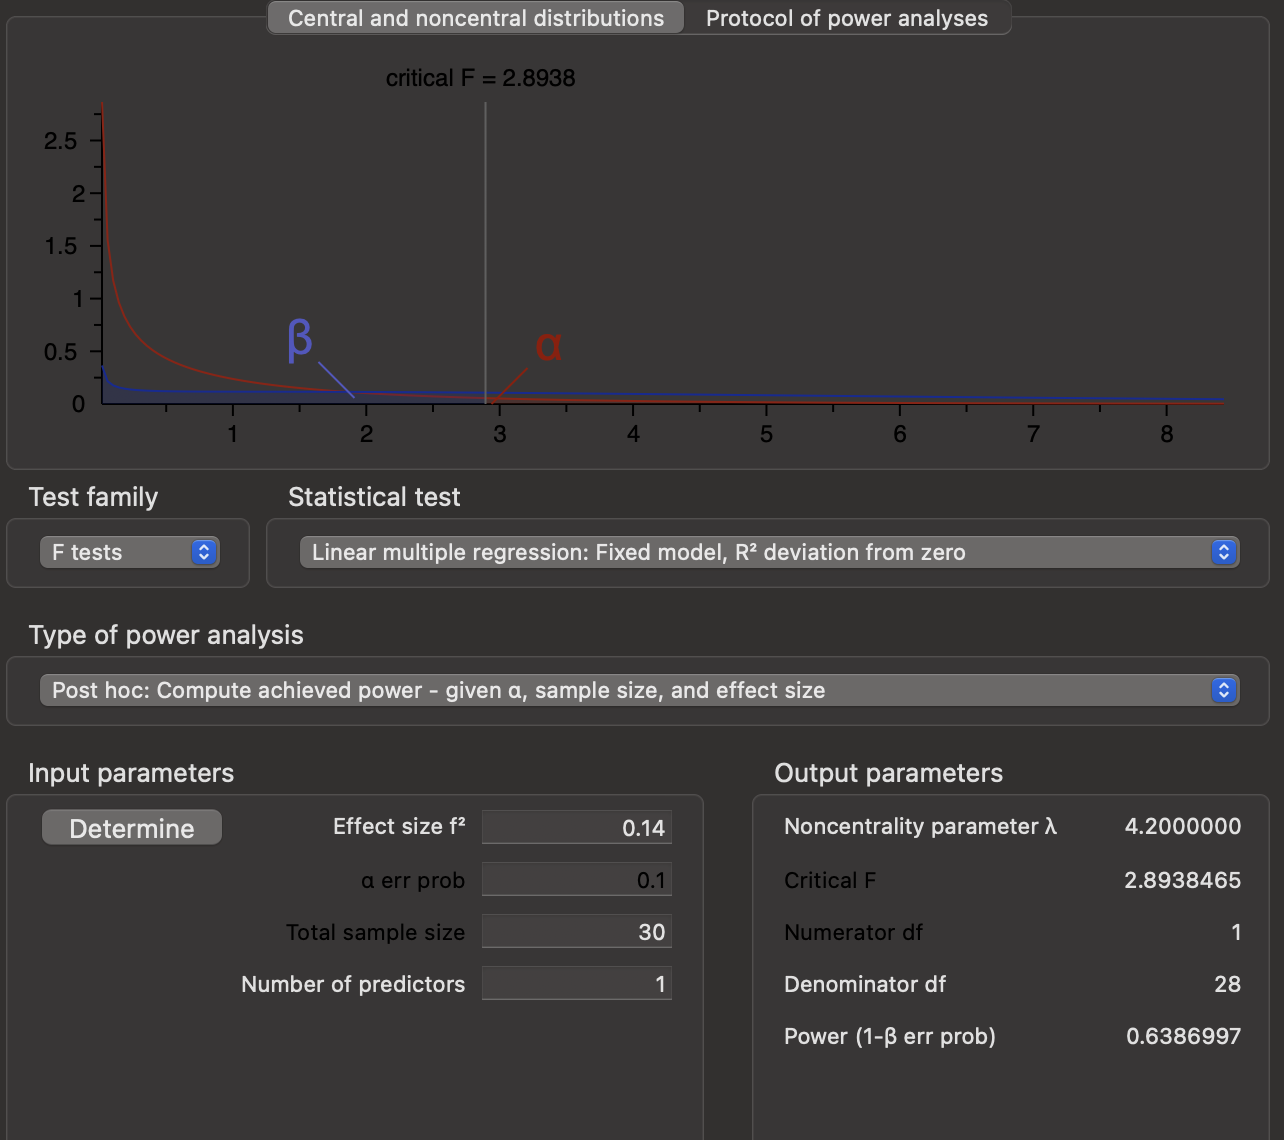

In [184]:
display.Image("img/power_achieved_ssimple_linear_CPA.png")

In [185]:
dont run yet

SyntaxError: invalid syntax (47826780.py, line 1)